# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


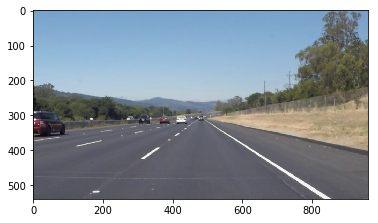

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [144]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # for line in lines:
    for x1,y1,x2,y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def filter_line_slope(lines, slope_min = 1.0/2.0, slop_max = 1.5):
    def slope_abs(line):
        x1, y1, x2, y2 = line
        return abs((y2-y1) * 1.0 / (x2-x1))
    
    return filter(lambda seg: slope_min <= slope_abs(seg) <= slop_max, lines)

def is_overlap(line1, line2):
    _, y1, _, y2 = line1
    _, y3, _, y4 = line2
    y1, y2 = sorted([y1, y2])
    y3, y4 = sorted([y3, y4])
    
    if y2 - 50 < y3 or y4 - 50 < y1:
        return False
    return True

def slope(line):
    x1, y1, x2, y2 = line
    return (y2 - y1) * 1.0 / (x2 - x1)
    
def intercept(line):
    x1, y1, x2, y2 = line
    return y1 - x1 * slope(line)
    
def is_same_line(line1, line2):
    # print(slope(line1), slope(line2), intercept(line1), intercept(line2))
    
    # if is_overlap(line1, line2):
        # return False
    return abs(slope(line1) - slope(line2)) < 0.8 and abs(intercept(line1) - intercept(line2)) < 200

def merge_segs(segs):
    points = []
    for s in segs:
        x1, y1, x2, y2 = s
        points.append((x1, y1))
        points.append((x2, y2))
        
    points.sort(key=lambda ele: ele[1])
    
    s = points[0]
    t = points[-1]
    # return (s[0], s[1], t[0], t[1])
    
    return tuple(segs[0])
    

def merge_lines(lines):
    res = set([])
    for l in lines:
        merged = False
        for r in res:
            if is_same_line(r, l):
                res.remove(r)
                res.add(merge_segs([l, r]))
                merged = True
                break
        if not merged:
            res.add(tuple(l))
        
    return list(res)

def line_length(line):
    x1, y1, x2, y2 = line
    return ((y2-y1) ** 2 + (x2-x1) ** 2) ** 0.5
 
def resize_line(line, y1, y2):
    k = slope(line)
    b = intercept(line)
    
    print(line, k, b)
    
    x1 = int((y1 - b) * 1.0 / k)
    x2 = int((y2 - b) * 1.0 / k)
    
    return (x1, y1, x2, y2)
    
def filter_line_length(lines, L):
    def line_length(line):
        x1, y1, x2, y2 = line
        return ((y2-y1) ** 2 + (x2-x1) ** 2) ** 0.5
    return filter(lambda l: line_length(l) > L, lines)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines_wrapper = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines = [l[0] for l in lines_wrapper]
    
    lines_in_scope = filter_line_slope(lines)
    merged_lines = merge_lines(lines_in_scope)
    long_lines = list(filter_line_length(merged_lines, 30))
    
    resized_lines = [resize_line(line, 320, 535) for line in long_lines]
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    '''
    for l in long_lines:
        print(l)
        
    for l in resized_lines:
        print(l)
    '''
    draw_lines(line_img, resized_lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [131]:
import os
os.listdir("test_images/")

print(is_same_line((280, 462, 341, 412), (386, 383, 463, 325)))

-0.08196721311475409 -0.07532467532467534 484.95081967213116 412.0753246753247
True


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(303, 434, 345, 405) -0.690476190476 643.214285714
(605, 391, 650, 419) 0.622222222222 14.5555555556


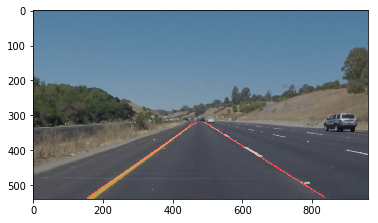

In [166]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

image1 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image2 = mpimg.imread('test_images/solidWhiteRight.jpg')
image3 = mpimg.imread('test_images/solidYellowCurve.jpg')
image4 = mpimg.imread('test_images/solidYellowCurve2.jpg')
image5 = mpimg.imread('test_images/solidYellowLeft.jpg')
image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

def process_image(image):
    imshape = image.shape

    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

    grey = gaussian_blur(grayscale(image), 5)
    # plt.imshow(grey)

    edges = canny(grey, 50, 150)

    region = np.array([[(50,imshape[0]),(460, 320), (480, 320), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, region)
    # plt.imshow(masked_edges)

    image_with_lines = hough_lines(masked_edges, rho = 2, theta = math.pi / 180.0, threshold = 15, min_line_len = 30, max_line_gap = 20)

    # plt.imshow(image_with_lines)

    return weighted_img(image_with_lines, image)

plt.imshow(process_image(image3))

In [151]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 383, 651, 414) 0.659574468085 -15.3829787234
(245, 483, 310, 431) -0.8 679.0
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 383, 651, 414) 0.659574468085 -15.3829787234
(245, 483, 310, 431) -0.8 679.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(618, 392, 677, 431) 

  1%|          | 2/222 [00:00<00:13, 16.39it/s]

0.661016949153 -16.5084745763
(166, 526, 212, 494) -0.695652173913 641.47826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(398, 365, 430, 343) -0.6875 638.625
(719, 447, 749, 465) 0.6 15.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  2%|▏         | 4/222 [00:00<00:13, 15.73it/s]

(651, 413, 713, 454) 0.661290322581 -17.5
(151, 537, 210, 494) -0.728813559322 647.050847458
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(739, 470, 774, 491) 0.6 26.6
(388, 370, 425, 342) -0.756756756757 663.621621622
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|▎         | 6/222 [00:00<00:13, 16.23it/s]

(384, 374, 455, 323) -0.718309859155 649.830985915
(707, 448, 766, 487) 0.661016949153 -19.3389830508
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(808, 513, 838, 531) 0.6 28.2
(396, 361, 440, 332) -0.659090909091 622.0


  4%|▎         | 8/222 [00:00<00:14, 15.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(335, 412, 369, 386) -0.764705882353 668.176470588
(698, 443, 733, 464) 0.6 24.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(740, 471, 772, 490) 0.59375 31.625
(409, 353, 460, 320) -0.647058823529 617.647058824
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  5%|▍         | 10/222 [00:00<00:14, 14.23it/s]

(387, 374, 464, 320) -0.701298701299 645.402597403
(701, 448, 793, 507) 0.641304347826 -1.55434782609
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(660, 419, 744, 469) 0.595238095238 26.1428571429
(309, 435, 340, 412) -0.741935483871 664.258064516
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  5%|▌         | 12/222 [00:00<00:15, 13.98it/s]

(734, 474, 784, 507) 0.66 -10.44
(267, 455, 316, 421) -0.69387755102 640.265306122
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  6%|▋         | 14/222 [00:00<00:14, 14.36it/s]

(406, 360, 455, 325) -0.714285714286 650.0
(586, 378, 622, 401) 0.638888888889 3.61111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(382, 374, 415, 350) -0.727272727273 651.818181818
(670, 433, 702, 453) 0.625 14.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(582, 372, 621, 397) 0.641025641026 -1.07692307692
(384, 375, 443, 333) -0.71186440678 648.355932203

  7%|▋         | 16/222 [00:01<00:13, 14.88it/s]


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(394, 364, 443, 329) -0.714285714286 645.428571429
(715, 450, 746, 468) 0.58064516129 34.8387096774


  8%|▊         | 18/222 [00:01<00:13, 15.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(404, 354, 442, 330) -0.631578947368 609.157894737
(641, 408, 674, 431) 0.69696969697 -38.7575757576
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(382, 372, 437, 334) -0.690909090909 635.927272727
(811, 510, 857, 538) 0.608695652174 16.347826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 363, 449, 328) -0.7 642.3
(761, 491, 798, 514) 0.621621621622 17.9459459459
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|▉         | 20/222 [00:01<00:13, 15.43it/s]

(332, 413, 371, 385) -0.717948717949 651.358974359
(720, 455, 755, 476) 0.6 23.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(721, 466, 771, 498) 0.64 4.56
(389, 372, 463, 320) -0.702702702703 645.351351351
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|▉         | 22/222 [00:01<00:12, 15.55it/s]

(384, 377, 415, 353) -0.774193548387 674.290322581
(689, 444, 730, 471) 0.658536585366 -9.73170731707
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█         | 24/222 [00:01<00:13, 14.67it/s]

(725, 468, 757, 488) 0.625 14.875
(409, 356, 454, 324) -0.711111111111 646.844444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(767, 485, 850, 535) 0.602409638554 22.9518072289
(369, 385, 423, 347) -0.703703703704 644.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(620, 391, 745, 469) 0.624 4.12
(396, 364, 450, 325) -0.722222222222 650.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|█▏        | 26/222 [00:01<00:14, 13.15it/s]

(174, 517, 226, 480) -0.711538461538 640.807692308
(779, 503, 833, 538) 0.648148148148 -1.90740740741
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(711, 458, 790, 510) 0.658227848101 -10.0
(195, 501, 253, 465) -0.620689655172 622.034482759


 13%|█▎        | 28/222 [00:01<00:14, 13.28it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(393, 367, 451, 325) -0.724137931034 651.586206897
(738, 476, 833, 538) 0.652631578947 -5.64210526316
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(390, 371, 427, 343) -0.756756756757 666.135135135
(623, 393, 856, 538) 0.622317596567 5.29613733906
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|█▎        | 30/222 [00:02<00:14, 13.25it/s]

(420, 351, 459, 321) -0.769230769231 674.076923077
(718, 462, 750, 482) 0.625 13.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 364, 438, 332) -0.820512820513 691.384615385
(583, 374, 658, 421) 0.626666666667 8.65333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 14%|█▍        | 32/222 [00:02<00:13, 14.15it/s]

(656, 414, 694, 436) 0.578947368421 34.2105263158
(393, 367, 453, 325) -0.7 642.1
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(798, 500, 858, 538) 0.633333333333 -5.4
(311, 422, 358, 389) -0.702127659574 640.361702128
This image is: <class 'numpy.ndarray'>

 15%|█▌        | 34/222 [00:02<00:12, 15.02it/s]

 with dimensions: (540, 960, 3)
(382, 374, 435, 334) -0.754716981132 662.301886792
(610, 386, 645, 408) 0.628571428571 2.57142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 361, 460, 321) -0.655737704918 622.639344262
(735, 463, 856, 538) 0.619834710744 7.42148760331
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|█▌        | 36/222 [00:02<00:11, 15.58it/s]

(394, 365, 430, 338) -0.75 660.5
(567, 364, 685, 443) 0.669491525424 -15.6016949153
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|█▋        | 38/222 [00:02<00:11, 16.39it/s]

(790, 510, 831, 537) 0.658536585366 -10.243902439
(206, 509, 312, 432) -0.72641509434 658.641509434
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(620, 400, 669, 431) 0.632653061224 7.75510204082
(403, 361, 448, 326) -0.777777777778 674.444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(412, 354, 448, 326) -0.777777777778 674.444444444
(573, 368, 605, 388) 0.625 9.875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|█▊        | 40/222 [00:02<00:10, 16.90it/s]

(396, 366, 451, 326) -0.727272727273 654.0
(725, 467, 769, 497) 0.681818181818 -27.3181818182
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 19%|█▉        | 42/222 [00:02<00:10, 17.02it/s]

(405, 357, 439, 331) -0.764705882353 666.705882353
(645, 407, 855, 538) 0.62380952381 4.64285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(419, 349, 451, 325) -0.75 663.25
(756, 487, 805, 520) 0.673469387755 -22.1428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(396, 360, 435, 333) -0.692307692308 634.153846154
(743, 479, 777, 502) 0.676470588235 -23.6176470588


 21%|██        | 46/222 [00:03<00:11, 14.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(332, 406, 366, 382) -0.705882352941 640.352941176
(676, 427, 727, 458) 0.607843137255 16.0980392157
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(804, 507, 853, 538) 0.632653061224 -1.65306122449
(389, 369, 455, 323) -0.69696969697 640.121212121
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(582, 372, 677, 436) 0.673684210526 -20.0842105263
(380, 371, 414, 351) -0.588235294118 594.529411765
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|██▏       | 48/222 [00:03<00:12, 14.29it/s]

(640, 404, 855, 539) 0.627906976744 2.13953488372
(301, 426, 338, 402) -0.648648648649 621.243243243
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(369, 382, 402, 355) -0.818181818182 683.909090909
(817, 516, 853, 538) 0.611111111111 16.7222222222
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(387, 368, 430, 336) -0.744186046512 656.0
(778, 492, 845, 533) 0.611940298507 15.9104477612
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|██▎       | 52/222 [00:03<00:11, 14.73it/s]

(700, 443, 741, 469) 0.634146341463 -0.90243902439
(238, 482, 280, 451) -0.738095238095 657.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(378, 376, 443, 329) -0.723076923077 649.323076923
(748, 484, 803, 519) 0.636363636364 8.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(391, 364, 443, 329) -0.673076923077 627.173076923
(778, 491, 809, 511) 0.645161290323 -10.935483871
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|██▍       | 54/222 [00:03<00:11, 14.90it/s]

(363, 386, 425, 341) -0.725806451613 649.467741935
(584, 373, 628, 403) 0.681818181818 -25.1818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(673, 424, 816, 516) 0.643356643357 -8.97902097902
(402, 359, 447, 327) -0.711111111111 644.866666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 361, 438, 335) -0.666666666667 627.0
(620, 391, 724, 456) 0.625 3.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(388, 364, 418, 346)

 26%|██▌       | 58/222 [00:03<00:11, 14.66it/s]

 -0.6 596.8
(726, 459, 772, 487) 0.608695652174 17.0869565217
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(316, 414, 350, 390) -0.705882352941 637.058823529
(561, 361, 632, 407) 0.647887323944 -2.46478873239
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(686, 436, 753, 477) 0.611940298507 16.2089552239
(295, 437, 345, 401) -0.72 649.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(568, 365, 815, 531) 0.672064777328 -16.7327935223
(373, 379, 442, 331) -0.695652173913 638.47826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|██▊       | 62/222 [00:04<00:10, 15.72it/s]

(391, 365, 463, 320) -0.625 609.375
(627, 399, 668, 424) 0.609756097561 16.6829268293
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(387, 370, 440, 333) -0.698113207547 640.169811321
(730, 476, 764, 498) 0.647058823529 3.64705882353
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(718, 457, 758, 483) 0.65 -9.7
(216, 493, 281, 444) -0.753846153846 655.830769231
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(569, 367, 602, 384) 0.515151515152 73.8787878788
(411, 355, 463, 320) -0.673076923077 631.634615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|██▉       | 66/222 [00:04<00:09, 16.41it/s]

(405, 354, 446, 327) -0.658536585366 620.707317073
(776, 508, 821, 538) 0.666666666667 -9.33333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(361, 388, 406, 359) -0.644444444444 620.644444444
(678, 432, 709, 453) 0.677419354839 -27.2903225806
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(689, 439, 745, 476) 0.660714285714 -16.2321428571
(401, 361, 462, 320) -0.672131147541 630.524590164
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(339, 400, 371, 380) -0.625 611.875
(716, 465, 805, 525) 0.674157303371 -17.6966292135
This image is:

 32%|███▏      | 70/222 [00:04<00:09, 16.44it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(580, 374, 633, 409) 0.660377358491 -9.01886792453
(407, 354, 444, 329) -0.675675675676 629.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(382, 367, 433, 334) -0.647058823529 614.176470588
(784, 500, 836, 532) 0.615384615385 17.5384615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(286, 431, 344, 395) -0.620689655172 608.517241379
(696, 444, 735, 470) 0.666666666667 -20.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(370, 377, 426, 339) -0.678571428571 628.071428571
(587, 380, 619, 400) 0.625 13.125


 33%|███▎      | 74/222 [00:04<00:08, 16.57it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 378, 803, 513) 0.645933014354 -5.68421052632
(407, 354, 452, 324) -0.666666666667 625.333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(660, 428, 794, 521) 0.694029850746 -30.0597014925
(263, 446, 300, 425) -0.567567567568 595.27027027
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(654, 418, 691, 442) 0.648648648649 -6.21621621622
(425, 344, 458, 321) -0.69696969697 640.212121212
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 387, 646, 413)

 35%|███▌      | 78/222 [00:05<00:08, 16.86it/s]

 0.619047619048 13.0952380952
(132, 532, 171, 506) -0.666666666667 620.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(124, 535, 209, 482) -0.623529411765 612.317647059
(760, 486, 819, 525) 0.661016949153 -16.3728813559
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(139, 538, 172, 514) -0.727272727273 639.090909091
(564, 365, 612, 397) 0.666666666667 -11.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(400, 357, 438, 334) -0.605263157895 599.105263158
(559, 362, 593, 385) 0.676470588235 -16.1470588235
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|███▋      | 82/222 [00:05<00:08, 16.77it/s]

(338, 400, 417, 345) -0.696202531646 635.316455696
(795, 511, 831, 535) 0.666666666667 -19.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(591, 379, 637, 408) 0.630434782609 6.41304347826
(319, 407, 362, 382) -0.581395348837 592.465116279
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(663, 426, 702, 451) 0.641025641026 1.0
(383, 369, 452, 324) -0.652173913043 618.782608696
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(374, 370, 406, 350) -0.625 603.75
(632, 412, 670, 440) 0.736842105263 -53.6842105263
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|███▊      | 84/222 [00:05<00:08, 16.43it/s]

(597, 382, 638, 410) 0.682926829268 -25.7073170732
(397, 361, 442, 330) -0.688888888889 634.488888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(236, 469, 319, 413) -0.674698795181 628.228915663
(623, 399, 678, 437) 0.690909090909 -31.4363636364
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(597, 383, 639, 410) 0.642857142857 -0.785714285714
(202, 493, 246, 463) -0.681818181818 630.727272727
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|███▉      | 88/222 [00:05<00:08, 15.99it/s]

(378, 372, 438, 332) -0.666666666667 624.0
(549, 355, 584, 379) 0.685714285714 -21.4571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(407, 353, 441, 330) -0.676470588235 628.323529412
(569, 365, 603, 388) 0.676470588235 -19.9117647059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(567, 369, 804, 535) 0.700421940928 -28.1392405063
(138, 538, 172, 514) -0.705882352941 635.411764706
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(683, 440, 735, 476) 0.692307692308 -32.8461538462
(383, 369, 458, 321) -0.64 614.12
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|████▏     | 92/222 [00:05<00:07, 16.59it/s]

(591, 385, 639, 418) 0.6875 -21.3125
(348, 393, 378, 375) -0.6 601.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(370, 378, 433, 334) -0.698412698413 636.412698413
(590, 379, 658, 424) 0.661764705882 -11.4411764706
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(391, 368, 449, 328) -0.689655172414 637.655172414
(549, 355, 585, 380) 0.694444444444 -26.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(385, 368, 434, 334) -0.69387755102 635.142857143
(718, 474, 772, 514) 0.740740740741 -57.8518518519
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|████▎     | 96/222 [00:06<00:07, 17.06it/s]

(679, 447, 779, 517) 0.7 -28.3
(286, 431, 338, 397) -0.653846153846 618.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(396, 362, 433, 335) -0.72972972973 650.972972973
(789, 510, 824, 534) 0.685714285714 -31.0285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(239, 469, 321, 414) -0.670731707317 629.304878049
(762, 503, 797, 529) 0.742857142857 -63.0571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(204, 494, 252, 462) -0.666666666667 630.0
(778, 515, 813, 538) 0.657142857143 3.74285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|████▌     | 100/222 [00:06<00:07, 16.50it/s]

(163, 522, 258, 456) -0.694736842105 635.242105263
(793, 514, 823, 533) 0.633333333333 11.7666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(376, 375, 455, 324) -0.645569620253 617.734177215
(604, 383, 712, 458) 0.694444444444 -36.4444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 363, 429, 339) -0.648648648649 617.27027027
(637, 405, 673, 429) 0.666666666667 -19.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(137, 538, 170, 516) 

 47%|████▋     | 104/222 [00:06<00:07, 16.82it/s]

-0.666666666667 629.333333333
(728, 467, 812, 525) 0.690476190476 -35.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(603, 389, 641, 417) 0.736842105263 -55.3157894737
(402, 359, 437, 332) -0.771428571429 669.114285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(686, 449, 720, 472) 0.676470588235 -15.0588235294
(422, 348, 464, 321) -0.642857142857 619.285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(334, 410, 370, 385) -0.694444444444 641.944444444
(667, 428, 708, 454) 0.634146341463 5.0243902439
This image is: <class 'numpy.ndarray'> with dimensions: 

 49%|████▊     | 108/222 [00:06<00:06, 16.86it/s]

(540, 960, 3)
(786, 506, 828, 533) 0.642857142857 0.714285714286
(389, 367, 435, 335) -0.695652173913 637.608695652
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(406, 358, 436, 338) -0.666666666667 628.666666667
(608, 391, 658, 428) 0.74 -58.92
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(614, 390, 653, 415) 0.641025641026 -3.58974358974
(281, 445, 319, 420) -0.657894736842 629.868421053
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(774, 507, 806, 531) 0.75 -73.5
(395, 363, 456, 322) -0.672131147541 628.491803279
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|█████     | 112/222 [00:07<00:06, 17.25it/s]

(197, 493, 304, 424) -0.644859813084 620.037383178
(609, 386, 658, 419) 0.673469387755 -24.1428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(416, 350, 447, 330) -0.645161290323 618.387096774
(770, 506, 815, 537) 0.688888888889 -24.4444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(663, 423, 696, 444) 0.636363636364 1.09090909091
(378, 376, 445, 334) -0.626865671642 612.955223881
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(735, 481, 796, 523) 0.688524590164 -25.0655737705
(412, 352, 445, 332) -0.606060606061 601.696969697
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|█████▏    | 114/222 [00:07<00:06, 16.78it/s]

(406, 357, 444, 332) -0.657894736842 624.105263158
(618, 390, 651, 413) 0.69696969697 -40.7272727273
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(417, 349, 459, 322) -0.642857142857 617.071428571
(614, 388, 644, 407) 0.633333333333 -0.866666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(590, 376, 639, 411) 0.714285714286 -45.4285714286
(399, 359, 450, 325) -0.666666666667 625.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(334, 406, 372, 382) -0.631578947368 616.947368421
(592, 377, 823, 539) 0.701298701299 -38.1688311688


 53%|█████▎    | 118/222 [00:07<00:06, 15.93it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(419, 347, 455, 323) -0.666666666667 626.333333333
(802, 509, 841, 536) 0.692307692308 -46.2307692308
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(648, 408, 701, 443) 0.660377358491 -19.9245283019
(383, 370, 463, 320) -0.625 609.375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(751, 487, 785, 509) 0.647058823529 1.05882352941
(381, 376, 460, 321) -0.696202531646 641.253164557
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|█████▍    | 122/222 [00:07<00:06, 16.17it/s]

(245, 461, 280, 437) -0.685714285714 629.0
(689, 436, 743, 469) 0.611111111111 14.9444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(654, 414, 796, 503) 0.62676056338 4.0985915493
(259, 452, 309, 421) -0.62 612.58
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(189, 513, 239, 476) -0.74 652.86
(667, 421, 729, 462) 0.661290322581 -20.0806451613
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(430, 346, 467, 320) -0.702702702703 648.162162162
(701, 443, 742, 470) 0.658536585366 -18.6341463415
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████▋    | 126/222 [00:08<00:05, 17.24it/s]

(638, 403, 670, 423) 0.625 4.25
(431, 343, 466, 320) -0.657142857143 626.228571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(368, 382, 460, 320) -0.673913043478 630.0
(588, 375, 629, 403) 0.682926829268 -26.5609756098
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(645, 406, 707, 444) 0.612903225806 10.6774193548
(420, 351, 466, 320) -0.673913043478 634.043478261
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(417, 353, 466, 320) -0.673469387755 633.836734694
(676, 432, 706, 453) 0.7 -41.2
This image is:

 59%|█████▊    | 130/222 [00:08<00:05, 16.21it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(396, 367, 466, 320) -0.671428571429 632.885714286
(822, 515, 858, 538) 0.638888888889 -10.1666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(422, 349, 457, 325) -0.685714285714 638.371428571
(816, 511, 847, 531) 0.645161290323 -15.4516129032
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(698, 438, 759, 477) 0.639344262295 -8.26229508197
(391, 372, 459, 324) -0.705882352941 648.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(303, 429, 341, 404) -0.657894736842 628.342105263
(731, 458, 771, 484) 0.65 -17.15
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|██████    | 134/222 [00:08<00:05, 16.25it/s]

(736, 473, 767, 492) 0.612903225806 21.9032258065
(263, 458, 299, 434) -0.666666666667 633.333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(422, 352, 467, 321) -0.688888888889 642.711111111
(705, 443, 746, 470) 0.658536585366 -21.2682926829
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(396, 371, 458, 321) -0.806451612903 690.35483871
(709, 445, 770, 484) 0.639344262295 -8.29508196721
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(166, 522, 213, 491) -0.659574468085 631.489361702
(804, 516, 839, 538) 0.628571428571 10.6285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|██████▏   | 138/222 [00:08<00:05, 16.42it/s]

(412, 353, 451, 325) -0.717948717949 648.794871795
(679, 424, 731, 457) 0.634615384615 -6.90384615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 383, 643, 408) 0.641025641026 -4.17948717949
(394, 366, 443, 329) -0.755102040816 663.510204082
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(616, 391, 678, 432) 0.661290322581 -16.3548387097
(383, 377, 447, 332) -0.703125 646.296875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(383, 375, 417, 352) -0.676470588235 634.088235294
(790, 494, 837, 522) 0.595744680851 23.3617021277
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|██████▍   | 142/222 [00:09<00:04, 16.00it/s]

(403, 366, 463, 321) -0.75 668.25
(652, 417, 766, 491) 0.649122807018 -6.22807017544
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(398, 368, 458, 327) -0.683333333333 639.966666667
(800, 502, 852, 533) 0.596153846154 25.0769230769
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(391, 375, 421, 354) -0.7 648.7
(622, 398, 653, 417) 0.612903225806 16.7741935484
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 66%|██████▌   | 146/222 [00:09<00:04, 15.91it/s]

(383, 379, 466, 321) -0.698795180723 646.638554217
(620, 391, 798, 502) 0.623595505618 4.37078651685
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(289, 442, 336, 411) -0.659574468085 632.617021277
(587, 375, 651, 415) 0.625 8.125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(396, 369, 459, 323) -0.730158730159 658.142857143
(660, 422, 717, 458) 0.631578947368 5.15789473684
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(596, 379, 841, 538) 0.648979591837 -7.79183673469
(394, 373, 424, 351) -0.733333333333 661.933333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 67%|██████▋   | 148/222 [00:09<00:04, 15.34it/s]

(156, 535, 230, 482) -0.716216216216 646.72972973
(653, 408, 685, 428) 0.625 -0.125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(167, 528, 213, 494) -0.739130434783 651.434782609
(790, 490, 832, 517) 0.642857142857 -17.8571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(169, 525, 200, 503) -0.709677419355 644.935483871
(742, 469, 795, 504) 0.660377358491 -21.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|██████▊   | 152/222 [00:09<00:04, 15.29it/s]

(422, 349, 458, 321) -0.777777777778 677.222222222
(775, 479, 807, 499) 0.625 -5.375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(404, 362, 460, 320) -0.75 665.0
(693, 432, 732, 454) 0.564102564103 41.0769230769
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(679, 431, 732, 466) 0.660377358491 -17.3962264151
(418, 354, 458, 325) -0.725 657.05
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 69%|██████▉   | 154/222 [00:09<00:04, 14.67it/s]

(684, 427, 733, 456) 0.591836734694 22.1836734694
(426, 349, 464, 321) -0.736842105263 662.894736842
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(806, 511, 848, 539) 0.666666666667 -26.3333333333
(395, 369, 460, 322) -0.723076923077 654.615384615
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(683, 424, 732, 455) 0.632653061224 -8.10204081633
(290, 443, 320, 420) -0.766666666667 665.333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|███████   | 158/222 [00:10<00:04, 14.98it/s]

(815, 504, 846, 524) 0.645161290323 -21.8064516129
(379, 380, 412, 354) -0.787878787879 678.606060606
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(243, 487, 294, 447) -0.78431372549 677.588235294
(701, 433, 755, 466) 0.611111111111 4.61111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(682, 429, 729, 460) 0.659574468085 -20.829787234
(398, 369, 463, 322) -0.723076923077 656.784615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(782, 482, 855, 525) 0.58904109589 21.3698630137
(187, 516, 231, 485) -0.704545454545 647.75


 72%|███████▏  | 160/222 [00:10<00:04, 14.69it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(840, 514, 879, 538) 0.615384615385 -2.92307692308
(205, 504, 241, 479) -0.694444444444 646.361111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(179, 539, 222, 503) -0.837209302326 688.860465116
(714, 439, 770, 473) 0.607142857143 5.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(434, 344, 467, 320) -0.727272727273 659.636363636
(815, 509, 849, 531) 0.647058823529 -18.3529411765


 74%|███████▍  | 164/222 [00:10<00:04, 13.51it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 376, 447, 336) -0.727272727273 661.090909091
(798, 487, 852, 520) 0.611111111111 -0.666666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(408, 365, 468, 321) -0.733333333333 664.2
(731, 448, 786, 479) 0.563636363636 35.9818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 75%|███████▍  | 166/222 [00:10<00:04, 13.52it/s]

(400, 369, 443, 334) -0.813953488372 694.581395349
(812, 494, 880, 534) 0.588235294118 16.3529411765
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(335, 425, 371, 396) -0.805555555556 694.861111111
(665, 416, 696, 436) 0.645161290323 -13.0322580645
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(708, 444, 746, 466) 0.578947368421 34.1052631579
(394, 378, 470, 320) -0.763157894737 678.684210526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(385, 383, 449, 330) -0.828125 701.828125
(770, 471, 886, 538) 

 77%|███████▋  | 170/222 [00:10<00:03, 14.48it/s]

0.577586206897 26.2586206897
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(242, 487, 299, 444) -0.754385964912 669.561403509
(620, 391, 661, 415) 0.585365853659 28.0731707317
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(678, 427, 863, 539) 0.605405405405 16.5351351351
(426, 352, 459, 327) -0.757575757576 674.727272727
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(634, 400, 674, 423) 0.575 35.45
(216, 521, 273, 474) -0.824561403509 699.105263158


 78%|███████▊  | 174/222 [00:11<00:03, 15.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(808, 494, 851, 519) 0.581395348837 24.2325581395
(424, 354, 467, 321) -0.767441860465 679.395348837
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(429, 349, 465, 322) -0.75 670.75
(702, 433, 766, 469) 0.5625 38.125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(643, 406, 862, 538) 0.602739726027 18.4383561644
(376, 391, 456, 327) -0.8 691.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|████████  | 178/222 [00:11<00:02, 15.40it/s]

(432, 346, 462, 323) -0.766666666667 677.2
(772, 473, 838, 511) 0.575757575758 28.5151515152
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(407, 366, 469, 321) -0.725806451613 661.403225806
(616, 389, 662, 416) 0.586956521739 27.4347826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(826, 504, 884, 538) 0.586206896552 19.7931034483
(405, 370, 468, 321) -0.777777777778 685.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(713, 440, 771, 474) 0.586206896552 22.0344827586
(421, 357, 467, 321) -0.782608695652 686.47826087


 81%|████████  | 180/222 [00:11<00:02, 15.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(395, 377, 453, 330) -0.810344827586 697.086206897
(713, 447, 746, 466) 0.575757575758 36.4848484848
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(712, 438, 887, 539) 0.577142857143 27.0742857143
(422, 354, 460, 324) -0.789473684211 687.157894737
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(427, 346, 461, 320) -0.764705882353 672.529411765
(787, 480, 845, 514) 0.586206896552 18.6551724138
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|████████▎ | 184/222 [00:11<00:02, 15.73it/s]

(815, 495, 890, 538) 0.573333333333 27.7333333333
(429, 349, 461, 324) -0.78125 684.15625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(789, 481, 819, 497) 0.533333333333 60.2
(223, 520, 256, 492) -0.848484848485 709.212121212
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(390, 375, 420, 351) -0.8 687.0
(781, 508, 826, 533) 0.555555555556 74.1111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(731, 448, 785, 480) 0.592592592593 14.8148148148
(385, 383, 421, 355) -0.777777777778 682.444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|████████▍ | 186/222 [00:12<00:02, 13.75it/s]

(374, 386, 452, 325) -0.782051282051 678.487179487
(777, 475, 846, 514) 0.565217391304 35.8260869565
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(426, 351, 458, 324) -0.84375 710.4375
(812, 494, 844, 514) 0.625 -13.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|████████▌ | 190/222 [00:12<00:02, 13.98it/s]

(420, 350, 458, 321) -0.763157894737 670.526315789
(743, 454, 802, 487) 0.559322033898 38.4237288136
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(401, 364, 440, 332) -0.820512820513 693.025641026
(868, 521, 898, 538) 0.566666666667 29.1333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(397, 365, 433, 336) -0.805555555556 684.805555556
(827, 505, 881, 538) 0.611111111111 -0.388888888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|████████▋ | 192/222 [00:12<00:02, 13.33it/s]

(833, 509, 884, 538) 0.56862745098 35.3333333333
(424, 349, 462, 320) -0.763157894737 672.578947368
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(417, 353, 466, 320) -0.673469387755 633.836734694
(697, 431, 820, 502) 0.577235772358 28.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(300, 455, 342, 422) -0.785714285714 690.714285714
(811, 491, 899, 538) 0.534090909091 57.8522727273


 87%|████████▋ | 194/222 [00:12<00:02, 12.85it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 370, 436, 340) -0.810810810811 693.513513514
(833, 515, 871, 538) 0.605263157895 10.8157894737
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(397, 370, 460, 327) -0.68253968254 640.968253968
(655, 409, 870, 538) 0.6 16.0


 88%|████████▊ | 196/222 [00:12<00:02, 11.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 380, 459, 328) -0.776119402985 684.23880597
(681, 427, 714, 446) 0.575757575758 34.9090909091
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(639, 401, 868, 538) 0.598253275109 18.7161572052
(180, 537, 229, 500) -0.755102040816 672.918367347
This image is:

 90%|█████████ | 200/222 [00:13<00:01, 11.94it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(751, 458, 890, 538) 0.575539568345 25.7697841727
(413, 359, 454, 326) -0.80487804878 691.414634146
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(845, 511, 888, 536) 0.581395348837 19.7209302326
(393, 375, 461, 320) -0.808823529412 692.867647059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(405, 363, 441, 334) -0.805555555556 689.25
(794, 494, 850, 527) 0.589285714286 26.1071428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(702, 438, 736, 457) 0.558823529412 45.7058823529
(339, 415, 376, 386) -0.783783783784 680.702702703


 92%|█████████▏| 204/222 [00:13<00:01, 14.01it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(398, 371, 457, 325) -0.779661016949 681.305084746
(793, 481, 850, 512) 0.543859649123 49.7192982456
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(693, 432, 744, 461) 0.56862745098 37.9411764706
(393, 375, 463, 321) -0.771428571429 678.171428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(838, 505, 882, 528) 0.522727272727 66.9545454545
(297, 458, 327, 433) -0.833333333333 705.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|█████████▎| 206/222 [00:13<00:01, 14.16it/s]

(278, 471, 343, 418) -0.815384615385 697.676923077
(730, 452, 795, 489) 0.569230769231 36.4615384615
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(401, 368, 432, 341) -0.870967741935 717.258064516
(760, 468, 792, 488) 0.625 -7.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(423, 350, 462, 323) -0.692307692308 642.846153846
(847, 507, 903, 538) 0.553571428571 38.125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(714, 439, 773, 475) 0.610169491525 3.33898305085
(430, 340, 462, 323) -0.53125 568.4375


 95%|█████████▍| 210/222 [00:13<00:00, 15.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(384, 381, 461, 321) -0.779220779221 680.220779221
(836, 511, 880, 536) 0.568181818182 36.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(399, 371, 448, 331) -0.816326530612 696.714285714
(828, 505, 881, 536) 0.584905660377 20.6981132075
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(393, 374, 462, 320) -0.782608695652 681.565217391
(859, 513, 906, 538) 0.531914893617 56.085106383
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|█████████▋| 214/222 [00:14<00:00, 15.74it/s]

(837, 502, 905, 538) 0.529411764706 58.8823529412
(407, 364, 445, 338) -0.684210526316 642.473684211
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(710, 440, 746, 460) 0.555555555556 45.5555555556
(404, 368, 443, 339) -0.74358974359 668.41025641
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(334, 427, 373, 392) -0.897435897436 726.743589744
(730, 453, 878, 539) 0.581081081081 28.8108108108
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(675, 420, 778, 480) 0.582524271845 26.7961165049
(305, 442, 336, 416) -0.838709677419 697.806451613
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████▊| 218/222 [00:14<00:00, 16.80it/s]

(419, 356, 458, 330) -0.666666666667 635.333333333
(653, 409, 683, 425) 0.533333333333 60.7333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(847, 511, 877, 527) 0.533333333333 59.2666666667
(378, 388, 416, 358) -0.789473684211 686.421052632
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(808, 489, 896, 539) 0.568181818182 29.9090909091
(438, 345, 469, 322) -0.741935483871 669.967741935
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(268, 480, 302, 450) -0.882352941176 716.470588235
(860, 517, 897, 538) 0.567567567568 28.8918918919
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|█████████▉| 221/222 [00:14<00:00, 15.30it/s]


(748, 465, 874, 538) 0.579365079365 31.6349206349
(388, 380, 462, 320) -0.810810810811 694.594594595
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(415, 357, 462, 320) -0.787234042553 683.70212766
(753, 468, 817, 504) 0.5625 44.4375
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.3 s, sys: 1.09 s, total: 11.4 s
Wall time: 15.7 s


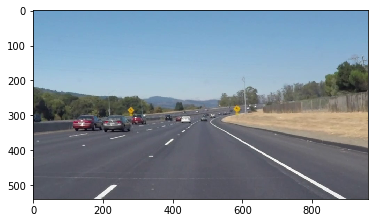

In [152]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [153]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(247, 460, 415, 355) -0.625 614.375
(718, 468, 759, 497) 0.707317073171 -39.8536585366
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  0%|          | 2/682 [00:00<00:45, 15.09it/s]

(247, 460, 415, 355) -0.625 614.375
(718, 468, 759, 497) 0.707317073171 -39.8536585366
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(689, 440, 725, 462) 0.611111111111 18.9444444444
(116, 532, 147, 514) -0.58064516129 599.35483871
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(750, 481, 839, 539) 0.651685393258 -7.76404494382
(129, 537, 159, 519) -0.6 614.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|          | 6/682 [00:00<00:41, 16.27it/s]

(173, 501, 208, 479) -0.628571428571 609.742857143
(742, 485, 787, 517) 0.711111111111 -42.6444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(371, 386, 454, 328) -0.698795180723 645.253012048
(784, 511, 822, 538) 0.710526315789 -46.0526315789
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(394, 372, 451, 332) -0.701754385965 648.49122807
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 380, 624, 400) 0.666666666667 -16.0
(408, 361, 438, 342) -0.633333333333 619.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  1%|▏         | 10/682 [00:00<00:40, 16.79it/s]

(600, 384, 638, 407) 0.605263157895 20.8421052632
(141, 538, 185, 509) -0.659090909091 630.931818182
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(190, 505, 248, 468) -0.637931034483 626.206896552
(609, 387, 650, 416) 0.707317073171 -43.756097561
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(619, 394, 669, 428) 0.68 -26.92
(398, 368, 449, 326) -0.823529411765 695.764705882
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(401, 366, 435, 341) -0.735294117647 660.852941176
(639, 401, 700, 440) 0.639344262295 -7.54098360656
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  2%|▏         | 14/682 [00:00<00:39, 16.96it/s]

(643, 409, 714, 459) 0.704225352113 -43.8169014085
(350, 403, 382, 374) -0.90625 720.1875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(204, 488, 261, 453) -0.614035087719 613.263157895
(707, 444, 737, 462) 0.6 19.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(237, 469, 277, 443) -0.65 623.05
(705, 452, 778, 499) 0.643835616438 -1.90410958904
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(402, 366, 443, 334) -0.780487804878 679.756097561
(717, 449, 858, 537) 0.624113475177 1.51063829787


  3%|▎         | 18/682 [00:01<00:39, 17.02it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(746, 468, 860, 539) 0.622807017544 3.38596491228
(179, 520, 303, 434) -0.693548387097 644.14516129
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(814, 510, 858, 536) 0.590909090909 29.0
(256, 458, 305, 425) -0.673469387755 630.408163265
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(394, 372, 437, 340) -0.744186046512 665.209302326
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  3%|▎         | 22/682 [00:01<00:36, 18.17it/s]

(594, 378, 625, 397) 0.612903225806 13.935483871
(136, 538, 167, 517) -0.677419354839 630.129032258
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(600, 381, 636, 404) 0.638888888889 -2.33333333333
(387, 378, 444, 332) -0.80701754386 690.315789474
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(608, 386, 644, 409) 0.638888888889 -2.44444444444
(154, 538, 411, 358) -0.700389105058 645.859922179
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(371, 386, 421, 343) -0.86 705.06
(623, 395, 668, 423) 0.622222222222 7.35555555556
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(325, 418, 355, 396) -0.733333333333 656.333333333
(645, 410, 690, 436) 0.577777777778 37.3333333333


  4%|▍         | 26/682 [00:01<00:39, 16.44it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(254, 458, 308, 421) -0.685185185185 632.037037037
(641, 408, 714, 453) 0.616438356164 12.8630136986
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(252, 471, 311, 429) -0.71186440678 650.389830508
(661, 420, 697, 443) 0.638888888889 -2.30555555556
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(185, 506, 301, 430) -0.655172413793 627.206896552
(675, 429, 706, 449) 0.645161290323 -6.48387096774


  4%|▍         | 28/682 [00:01<00:46, 14.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(384, 379, 429, 344) -0.777777777778 677.666666667
(791, 501, 830, 528) 0.692307692308 -46.6153846154
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(834, 515, 872, 538) 0.605263157895 10.2105263158
(204, 506, 240, 482) -0.666666666667 642.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(239, 482, 273, 461) -0.617647058824 629.617647059
(779, 491, 854, 539) 0.64 -7.56


  4%|▍         | 30/682 [00:01<00:44, 14.49it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(164, 537, 390, 373) -0.725663716814 656.008849558
(816, 513, 857, 539) 0.634146341463 -4.46341463415
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(277, 456, 312, 430) -0.742857142857 661.771428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(164, 538, 200, 511) -0.75 661.0


  5%|▍         | 34/682 [00:02<00:42, 15.27it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(231, 489, 310, 432) -0.721518987342 655.670886076
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(228, 480, 287, 441) -0.661016949153 630.711864407
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(639, 401, 682, 427) 0.604651162791 14.6279069767
(362, 394, 401, 364) -0.769230769231 672.461538462
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(647, 406, 705, 441) 0.603448275862 15.5689655172
(312, 432, 358, 396) -0.782608695652 676.173913043


  6%|▌         | 38/682 [00:02<00:44, 14.63it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(692, 435, 727, 456) 0.6 19.8
(169, 537, 233, 489) -0.75 663.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(738, 462, 768, 482) 0.666666666667 -30.0
(268, 463, 326, 420) -0.741379310345 661.689655172
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(706, 435, 750, 461) 0.590909090909 17.8181818182
(320, 416, 354, 391) -0.735294117647 651.294117647


  6%|▌         | 42/682 [00:02<00:45, 14.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(193, 505, 243, 468) -0.74 647.82
(720, 445, 763, 467) 0.511627906977 76.6279069767
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(801, 490, 850, 518) 0.571428571429 32.2857142857
(369, 379, 411, 347) -0.761904761905 660.142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(815, 498, 882, 538) 0.597014925373 11.4328358209
(165, 538, 207, 506) -0.761904761905 663.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(379, 371, 410, 353) -0.58064516129 591.064516129
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  7%|▋         | 46/682 [00:03<00:53, 11.85it/s]

(143, 539, 336, 404) -0.699481865285 639.025906736
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(338, 403, 389, 365) -0.745098039216 654.843137255
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(618, 390, 655, 411) 0.567567567568 39.2432432432
(145, 539, 201, 499) -0.714285714286 642.571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(619, 391, 670, 422) 0.607843137255 14.7450980392
(340, 400, 371, 379) -0.677419354839 630.322580645
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(630, 398, 690, 435) 0.616666666667 9.5
(343, 405, 373, 389) -0.533333333333 587.933333333


  7%|▋         | 50/682 [00:03<01:02, 10.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(683, 424, 715, 441) 0.53125 61.15625
(165, 538, 246, 479) -0.728395061728 658.185185185
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(282, 442, 410, 349) -0.7265625 646.890625
(670, 422, 705, 443) 0.6 20.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  8%|▊         | 52/682 [00:03<01:01, 10.17it/s]

(192, 504, 262, 456) -0.685714285714 635.657142857
(690, 434, 732, 460) 0.619047619048 6.85714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(179, 514, 344, 398) -0.70303030303 639.842424242
(711, 440, 742, 457) 0.548387096774 50.0967741935
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  8%|▊         | 54/682 [00:04<01:07,  9.31it/s]

(389, 369, 440, 331) -0.745098039216 658.843137255
(838, 513, 877, 538) 0.641025641026 -24.1794871795
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(375, 374, 405, 354) -0.666666666667 624.0
(759, 481, 809, 509) 0.56 55.96
This image is: 

  8%|▊         | 57/682 [00:04<01:03,  9.92it/s]

<class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(814, 512, 855, 539) 0.658536585366 -24.0487804878
(171, 519, 284, 440) -0.699115044248 638.548672566
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(319, 423, 362, 389) -0.790697674419 675.23255814
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(167, 534, 237, 484) -0.714285714286 653.285714286
(600, 381, 630, 397) 0.533333333333 61.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


  9%|▊         | 59/682 [00:04<01:04,  9.63it/s]

(229, 490, 280, 451) -0.764705882353 665.117647059
(601, 382, 642, 406) 0.585365853659 30.1951219512
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(222, 494, 253, 470) -0.774193548387 665.870967742
(610, 388, 650, 412) 0.6 22.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(212, 501, 244, 476) -0.78125 666.625
(643, 403, 680, 427) 0.648648648649 -14.0810810811
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(343, 398, 420, 342)

  9%|▉         | 62/682 [00:04<01:14,  8.32it/s]

 -0.727272727273 647.454545455
(642, 403, 674, 420) 0.53125 61.9375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(138, 538, 177, 510) -0.717948717949 637.076923077
(682, 427, 728, 454) 0.586956521739 26.6956521739
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(704, 440, 753, 469) 0.591836734694 23.3469387755
(304, 424, 339, 398) -0.742857142857 649.828571429


 10%|▉         | 65/682 [00:05<01:05,  9.46it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(332, 411, 370, 382) -0.763157894737 664.368421053
(763, 483, 806, 510) 0.627906976744 3.90697674419
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(774, 482, 804, 497) 0.5 95.0
(387, 367, 422, 340) -0.771428571429 665.542857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 10%|▉         | 66/682 [00:05<01:08,  8.99it/s]

(368, 386, 414, 352) -0.739130434783 658.0
(743, 464, 802, 497) 0.559322033898 48.4237288136
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(240, 468, 276, 444) -0.666666666667 628.0
(787, 490, 822, 510) 0.571428571429 40.2857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(196, 510, 248, 474) -0.692307692308 645.692307692


 10%|█         | 70/682 [00:05<01:00, 10.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(589, 376, 619, 394) 0.6 22.6
(342, 400, 372, 379) -0.7 639.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 379, 629, 401) 0.628571428571 5.62857142857
(296, 431, 423, 342) -0.700787401575 638.433070866
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█         | 72/682 [00:05<01:03,  9.63it/s]

(283, 440, 315, 417) -0.71875 643.40625
(602, 384, 642, 409) 0.625 7.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(246, 475, 284, 447) -0.736842105263 656.263157895
(621, 398, 657, 420) 0.611111111111 18.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 11%|█         | 74/682 [00:06<01:00, 10.08it/s]

(228, 487, 273, 456) -0.688888888889 644.066666667
(620, 397, 679, 432) 0.593220338983 29.2033898305
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(206, 503, 250, 473) -0.681818181818 643.454545455
(679, 427, 710, 448) 0.677419354839 -32.9677419355
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(352, 400, 453, 324) -0.752475247525 664.871287129
(646, 415, 727, 467) 0.641975308642 0.283950617284


 11%|█▏        | 78/682 [00:06<00:52, 11.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(708, 447, 775, 486) 0.582089552239 34.8805970149
(387, 373, 436, 338) -0.714285714286 649.428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(360, 394, 454, 323) -0.755319148936 665.914893617
(769, 484, 840, 527) 0.605633802817 18.2676056338
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(792, 509, 841, 538) 0.591836734694 40.2653061224
(231, 476, 266, 451) -0.714285714286 641.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|█▏        | 80/682 [00:06<00:52, 11.40it/s]

(798, 500, 860, 538) 0.612903225806 10.9032258065
(276, 445, 311, 420) -0.714285714286 642.142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(787, 505, 840, 538) 0.622641509434 14.9811320755
(241, 469, 275, 445) -0.705882352941 639.117647059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 12%|█▏        | 82/682 [00:06<00:53, 11.17it/s]

(323, 420, 358, 393) -0.771428571429 669.171428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(588, 377, 622, 396) 0.558823529412 48.4117647059
(417, 349, 450, 325) -0.727272727273 652.272727273
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(367, 381, 413, 347) -0.739130434783 652.260869565
(591, 379, 630, 404) 0.641025641026 0.153846153846
This image is:

 13%|█▎        | 86/682 [00:07<00:47, 12.49it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(602, 385, 643, 412) 0.658536585366 -11.4390243902
(234, 472, 301, 424) -0.716417910448 639.641791045
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(162, 520, 272, 445) -0.681818181818 630.454545455
(606, 390, 657, 422) 0.627450980392 9.76470588235
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(416, 351, 448, 326) -0.78125 676.0
(620, 397, 680, 437) 0.666666666667 -16.3333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(643, 405, 717, 451) 0.621621621622 5.2972972973
(298, 427, 328, 406) -0.7 635.6


 13%|█▎        | 88/682 [00:07<00:45, 13.14it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(646, 414, 677, 434) 0.645161290323 -2.77419354839
(390, 369, 429, 337) -0.820512820513 689.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(202, 501, 263, 459) -0.688524590164 640.081967213
(658, 421, 739, 474) 0.654320987654 -9.54320987654
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(788, 508, 834, 537) 0.630434782609 11.2173913043
(276, 441, 306, 420) -0.7 634.2


 13%|█▎        | 92/682 [00:07<00:47, 12.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(717, 454, 771, 485) 0.574074074074 42.3888888889
(131, 538, 165, 515) -0.676470588235 626.617647059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(310, 421, 414, 349) -0.692307692308 635.615384615
(734, 474, 833, 539) 0.656565656566 -7.91919191919
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(815, 516, 853, 539) 0.605263157895 22.7105263158
(355, 392, 407, 356) -0.692307692308 637.769230769


 14%|█▍        | 94/682 [00:07<00:48, 12.08it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(560, 361, 612, 390) 0.557692307692 48.6923076923
(233, 484, 294, 442) -0.688524590164 644.426229508
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(136, 539, 168, 517) -0.6875 632.5
(586, 380, 616, 399) 0.633333333333 8.86666666667


 14%|█▍        | 98/682 [00:07<00:45, 12.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(599, 382, 634, 404) 0.628571428571 5.48571428571
(244, 477, 278, 454) -0.676470588235 642.058823529
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(279, 451, 313, 428) -0.676470588235 639.735294118
(604, 386, 634, 403) 0.566666666667 43.7333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(624, 404, 657, 424) 0.606060606061 25.8181818182
(167, 531, 207, 504) -0.675 643.725
This image is:

 15%|█▍        | 100/682 [00:08<00:45, 12.77it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(627, 404, 675, 436) 0.666666666667 -14.0
(327, 409, 378, 375) -0.666666666667 627.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(641, 406, 709, 448) 0.617647058824 10.0882352941
(330, 414, 387, 375) -0.684210526316 639.789473684
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(681, 439, 722, 467) 0.682926829268 -26.0731707317
(172, 514, 417, 349) -0.673469387755 629.836734694
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 15%|█▍        | 102/682 [00:08<00:47, 12.17it/s]

(179, 509, 209, 488) -0.7 634.3
(663, 427, 695, 448) 0.65625 -8.09375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(383, 378, 427, 346) -0.727272727273 656.545454545
(790, 510, 821, 531) 0.677419354839 -25.1612903226
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|█▌        | 106/682 [00:08<00:46, 12.49it/s]

(781, 504, 831, 537) 0.66 -11.46
(154, 538, 413, 356) -0.702702702703 646.216216216
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(751, 476, 790, 498) 0.564102564103 52.358974359
(208, 489, 259, 454) -0.686274509804 631.745098039
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(795, 513, 833, 538) 0.657894736842 -10.0263157895
(360, 388, 390, 366) -0.733333333333 652.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 16%|█▌        | 108/682 [00:08<00:49, 11.53it/s]

(133, 538, 175, 509) -0.690476190476 629.833333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(590, 379, 622, 399) 0.625 10.25
(213, 486, 243, 465) -0.7 635.1
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(597, 384, 632, 407) 0.657142857143 -8.31428571429
(398, 368, 459, 321) -0.770491803279 674.655737705


 16%|█▋        | 112/682 [00:09<00:41, 13.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(393, 372, 426, 346) -0.787878787879 681.636363636
(609, 392, 648, 417) 0.641025641026 1.61538461538
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(618, 394, 668, 424) 0.6 23.2
(135, 539, 180, 508) -0.688888888889 632.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(324, 420, 355, 402) -0.58064516129 608.129032258
(627, 401, 672, 425) 0.533333333333 66.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|█▋        | 114/682 [00:09<00:39, 14.28it/s]

(669, 432, 710, 458) 0.634146341463 7.75609756098
(359, 390, 397, 369) -0.552631578947 588.394736842
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(660, 419, 755, 476) 0.6 23.0
(137, 539, 171, 515) -0.705882352941 635.705882353
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(243, 468, 285, 439) -0.690476190476 635.785714286
(750, 472, 805, 506) 0.618181818182 8.36363636364
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 17%|█▋        | 116/682 [00:09<00:43, 12.99it/s]

(745, 479, 783, 504) 0.657894736842 -11.1315789474
(345, 400, 405, 357) -0.716666666667 647.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(782, 504, 834, 537) 0.634615384615 7.73076923077
(367, 391, 440, 336) -0.753424657534 667.506849315
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(761, 488, 815, 524) 0.666666666667 -19.3333333333
(235, 473, 276, 445) -0.682926829268 633.487804878


 18%|█▊        | 120/682 [00:09<00:41, 13.43it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(294, 443, 464, 320) -0.723529411765 655.717647059
(829, 520, 860, 538) 0.58064516129 38.6451612903
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(402, 360, 446, 327) -0.75 661.5
(590, 379, 622, 397) 0.5625 47.125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(606, 384, 637, 403) 0.612903225806 12.5806451613
(198, 510, 233, 486) -0.685714285714 645.771428571


 18%|█▊        | 122/682 [00:09<00:41, 13.43it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(398, 363, 445, 328) -0.744680851064 659.382978723
(610, 386, 652, 412) 0.619047619048 8.38095238095
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(269, 453, 456, 322) -0.700534759358 641.443850267
(613, 394, 660, 424) 0.63829787234 2.72340425532
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|█▊        | 124/682 [00:10<00:47, 11.74it/s]

(269, 463, 316, 427) -0.765957446809 669.042553191
(627, 403, 677, 436) 0.66 -10.82
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(316, 428, 348, 403) -0.78125 674.875
(650, 417, 704, 453) 0.666666666667 -16.3333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 18%|█▊        | 126/682 [00:10<00:56,  9.85it/s]

(665, 419, 750, 472) 0.623529411765 4.35294117647
(344, 401, 460, 320) -0.698275862069 641.206896552
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(393, 368, 448, 328) -0.727272727273 653.818181818
(742, 468, 792, 498) 0.6 22.8


 19%|█▉        | 128/682 [00:10<01:00,  9.09it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(327, 413, 361, 389) -0.705882352941 643.823529412
(782, 502, 838, 538) 0.642857142857 -0.714285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 19%|█▉        | 131/682 [00:10<01:01,  8.97it/s]

(225, 495, 451, 331) -0.725663716814 658.274336283
(731, 460, 774, 485) 0.581395348837 35.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(750, 481, 839, 539) 0.651685393258 -7.76404494382
(420, 354, 466, 320) -0.739130434783 664.434782609
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(797, 511, 839, 538) 0.642857142857 -1.35714285714
(404, 361, 461, 320) -0.719298245614 651.596491228
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|█▉        | 133/682 [00:11<01:04,  8.48it/s]

(387, 372, 431, 340) -0.727272727273 653.454545455
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(366, 387, 462, 320) -0.697916666667 642.4375
(593, 380, 624, 400) 0.645161290323 -2.58064516129
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 20%|█▉        | 135/682 [00:11<00:59,  9.16it/s]

(600, 386, 636, 408) 0.611111111111 19.3333333333
(299, 433, 407, 358) -0.694444444444 640.638888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(609, 391, 651, 418) 0.642857142857 -0.5
(400, 369, 456, 324) -0.803571428571 690.428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(626, 396, 678, 427) 0.596153846154 22.8076923077
(332, 411, 362, 389) -0.733333333333 654.466666667


 20%|██        | 138/682 [00:11<00:56,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(275, 450, 323, 416) -0.708333333333 644.791666667
(631, 403, 674, 434) 0.720930232558 -51.9069767442
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(229, 479, 285, 442) -0.660714285714 630.303571429
(643, 414, 681, 439) 0.657894736842 -9.02631578947
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|██        | 140/682 [00:11<00:52, 10.28it/s]

(715, 451, 762, 479) 0.595744680851 25.0425531915
(208, 494, 239, 472) -0.709677419355 641.612903226
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(749, 482, 796, 512) 0.63829787234 3.91489361702
(142, 538, 357, 393) -0.674418604651 633.76744186
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(714, 449, 756, 474) 0.595238095238 24.0
(331, 411, 369, 384) -0.710526315789 646.184210526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|██        | 142/682 [00:12<00:54,  9.91it/s]

(143, 538, 369, 385) -0.676991150442 634.809734513
(784, 492, 831, 520) 0.595744680851 24.9361702128
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(337, 407, 371, 382) -0.735294117647 654.794117647
(784, 493, 849, 531) 0.584615384615 34.6615384615
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 21%|██▏       | 146/682 [00:12<00:49, 10.72it/s]

(230, 480, 286, 440) -0.714285714286 644.285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(160, 528, 268, 453) -0.694444444444 639.111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(163, 538, 221, 497) -0.706896551724 653.224137931
(598, 385, 628, 404) 0.633333333333 6.26666666667
This image is: <class 'numpy.ndarray'>

 22%|██▏       | 148/682 [00:12<00:53,  9.90it/s]

 with dimensions: (540, 960, 3)
(608, 386, 651, 411) 0.581395348837 32.511627907
(360, 389, 395, 371) -0.514285714286 574.142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(374, 379, 425, 350) -0.56862745098 591.666666667
(627, 397, 669, 422) 0.595238095238 23.7857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 22%|██▏       | 150/682 [00:12<00:50, 10.59it/s]

(624, 400, 654, 419) 0.633333333333 4.8
(330, 417, 380, 381) -0.72 654.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(669, 428, 704, 451) 0.657142857143 -11.6285714286
(414, 358, 459, 321) -0.822222222222 698.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(164, 537, 197, 514) -0.69696969697 651.303030303
(651, 417, 706, 452) 0.636363636364 2.72727272727


 22%|██▏       | 152/682 [00:12<00:51, 10.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(676, 427, 792, 497) 0.603448275862 19.0689655172
(220, 497, 250, 477) -0.666666666667 643.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(262, 457, 298, 433) -0.666666666667 631.666666667
(706, 443, 741, 464) 0.6 19.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|██▎       | 156/682 [00:13<00:46, 11.41it/s]

(307, 436, 373, 387) -0.742424242424 663.924242424
(805, 515, 842, 538) 0.621621621622 14.5945945946
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(803, 501, 851, 530) 0.604166666667 15.8541666667
(411, 359, 464, 321) -0.716981132075 653.679245283
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(813, 509, 864, 539) 0.588235294118 30.7647058824
(417, 356, 450, 333) -0.69696969697 646.636363636
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|██▎       | 158/682 [00:13<00:41, 12.69it/s]

(429, 349, 462, 323) -0.787878787879 687.0
(594, 378, 625, 396) 0.58064516129 33.0967741935
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(234, 481, 311, 429) -0.675324675325 639.025974026
(598, 384, 632, 404) 0.588235294118 32.2352941176
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(171, 538, 229, 497) -0.706896551724 658.879310345
(610, 388, 643, 407) 0.575757575758 36.7878787879
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 23%|██▎       | 160/682 [00:13<00:45, 11.46it/s]

(348, 405, 408, 364) -0.683333333333 642.8
(554, 358, 585, 376) 0.58064516129 36.3225806452
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(625, 402, 676, 433) 0.607843137255 22.0980392157
(155, 538, 204, 503) -0.714285714286 648.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|██▍       | 164/682 [00:14<00:46, 11.25it/s]

(266, 462, 315, 427) -0.714285714286 652.0
(645, 412, 676, 431) 0.612903225806 16.6774193548
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(221, 492, 251, 471) -0.7 646.7
(693, 435, 735, 458) 0.547619047619 55.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(180, 535, 253, 480) -0.753424657534 670.616438356
(724, 459, 762, 483) 0.631578947368 1.73684210526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 24%|██▍       | 166/682 [00:14<00:43, 11.95it/s]

(354, 409, 400, 376) -0.717391304348 662.956521739
(765, 485, 813, 513) 0.583333333333 38.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(241, 480, 293, 443) -0.711538461538 651.480769231
(735, 457, 773, 478) 0.552631578947 50.8157894737
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(827, 510, 877, 538) 0.56 46.88
(174, 539, 210, 512) -0.75 669.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|██▍       | 168/682 [00:14<00:39, 12.99it/s]

(315, 437, 381, 390) -0.712121212121 661.318181818
(822, 506, 879, 538) 0.561403508772 44.5263157895
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(318, 435, 433, 351) -0.730434782609 667.27826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 25%|██▌       | 172/682 [00:14<00:44, 11.40it/s]

(600, 381, 634, 399) 0.529411764706 63.3529411765
(200, 510, 249, 475) -0.714285714286 652.857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(607, 385, 646, 407) 0.564102564103 42.5897435897
(323, 432, 361, 405) -0.710526315789 661.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(161, 539, 389, 379) -0.701754385965 651.98245614
(617, 391, 660, 415) 0.558139534884 46.6279069767


 26%|██▌       | 174/682 [00:14<00:42, 12.06it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(343, 412, 376, 387) -0.757575757576 671.848484848
(626, 396, 679, 426) 0.566037735849 41.6603773585
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(181, 538, 212, 515) -0.741935483871 672.290322581
(637, 402, 698, 438) 0.590163934426 26.0655737705
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|██▌       | 176/682 [00:15<00:48, 10.47it/s]

(694, 436, 726, 453) 0.53125 67.3125
(267, 477, 311, 442) -0.795454545455 689.386363636
(368, 410, 393, 374) -1.44 939.92
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(668, 419, 759, 473) 0.593406593407 22.6043956044
(354, 410, 387, 386) -0.727272727273 667.454545455
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|██▌       | 178/682 [00:15<00:45, 11.03it/s]

(374, 395, 406, 371) -0.75 675.5
(767, 470, 800, 488) 0.545454545455 51.6363636364
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(295, 458, 348, 416) -0.792452830189 691.773584906
(721, 443, 794, 485) 0.575342465753 28.1780821918
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 26%|██▋       | 180/682 [00:15<00:56,  8.96it/s]

(807, 492, 865, 522) 0.51724137931 74.5862068966
(281, 470, 433, 351) -0.782894736842 689.993421053
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(828, 513, 871, 538) 0.581395348837 31.6046511628
(250, 482, 357, 402) -0.747663551402 668.91588785
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(831, 512, 874, 538) 0.604651162791 9.53488372093
(227, 498, 394, 376) -0.730538922156 663.832335329
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|██▋       | 184/682 [00:15<00:42, 11.62it/s]

(358, 402, 464, 320) -0.77358490566 678.943396226
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(433, 348, 467, 321) -0.794117647059 691.852941176
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(615, 389, 653, 411) 0.578947368421 32.9473684211
(389, 383, 419, 361) -0.733333333333 668.266666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(229, 511, 277, 474) -0.770833333333 687.520833333
(624, 395, 677, 422) 0.509433962264 77.1132075472
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 27%|██▋       | 186/682 [00:15<00:42, 11.65it/s]

(633, 399, 693, 433) 0.566666666667 40.3
(372, 397, 405, 373) -0.727272727273 667.545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(414, 359, 465, 322) -0.725490196078 659.352941176
(677, 426, 720, 448) 0.511627906977 79.6279069767
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|██▊       | 188/682 [00:16<00:45, 10.82it/s]

(253, 480, 304, 441) -0.764705882353 673.470588235
(701, 433, 758, 463) 0.526315789474 64.0526315789
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(237, 492, 288, 453) -0.764705882353 673.235294118
(679, 427, 713, 445) 0.529411764706 67.5294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|██▊       | 190/682 [00:16<00:54,  9.07it/s]

(792, 483, 834, 505) 0.52380952381 68.1428571429
(333, 429, 436, 346) -0.805825242718 697.339805825
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(327, 425, 461, 321) -0.776119402985 678.791044776
(795, 485, 894, 538) 0.535353535354 59.3939393939
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 28%|██▊       | 192/682 [00:16<00:52,  9.31it/s]

(783, 486, 874, 538) 0.571428571429 38.5714285714
(310, 436, 355, 404) -0.711111111111 656.444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(180, 534, 220, 503) -0.775 673.5
(808, 502, 871, 537) 0.555555555556 53.1111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(426, 348, 457, 323) -0.806451612903 691.548387097
(590, 376, 621, 393) 0.548387096774 52.4516129032


 29%|██▊       | 196/682 [00:17<00:48,  9.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(393, 371, 456, 323) -0.761904761905 670.428571429
(596, 380, 633, 399) 0.513513513514 73.9459459459
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(283, 454, 313, 433) -0.7 652.1
(604, 385, 642, 406) 0.552631578947 51.2105263158
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(612, 389, 658, 415) 0.565217391304

 29%|██▉       | 198/682 [00:17<00:50,  9.62it/s]

 43.0869565217
(408, 366, 447, 330) -0.923076923077 742.615384615
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(555, 358, 587, 375) 0.53125 63.15625
(238, 502, 273, 473) -0.828571428571 699.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(633, 402, 663, 419) 0.566666666667 43.3
(170, 539, 461, 320) -0.752577319588 666.93814433


 29%|██▉       | 200/682 [00:17<00:51,  9.33it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(233, 492, 461, 320) -0.754385964912 667.771929825
(647, 412, 724, 456) 0.571428571429 42.2857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(726, 448, 756, 466) 0.6 12.4
(231, 492, 266, 465) -0.771428571429 670.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|██▉       | 204/682 [00:17<00:44, 10.70it/s]

(296, 452, 344, 415) -0.770833333333 680.166666667
(727, 451, 776, 478) 0.551020408163 50.4081632653
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(748, 463, 809, 496) 0.540983606557 58.3442622951
(326, 428, 382, 385) -0.767857142857 678.321428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(783, 483, 849, 521) 0.575757575758 32.1818181818
(290, 458, 324, 430) -0.823529411765 696.823529412
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 30%|███       | 206/682 [00:18<00:46, 10.30it/s]

(166, 538, 285, 451) -0.731092436975 659.361344538
(823, 517, 858, 538) 0.6 23.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(397, 378, 433, 347) -0.861111111111 719.861111111
(827, 521, 857, 539) 0.6 24.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 31%|███       | 210/682 [00:18<00:38, 12.21it/s]

(382, 385, 418, 359) -0.722222222222 660.888888889
(594, 379, 626, 397) 0.5625 44.875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(601, 383, 639, 404) 0.552631578947 50.8684210526
(183, 538, 290, 455) -0.775700934579 679.953271028
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(282, 462, 395, 374) -0.778761061947 681.610619469
(610, 387, 653, 412) 0.581395348837 32.3488372093
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(241, 480, 275, 455) -0.735294117647 657.205882353
(526, 343, 584, 375) 0.551724137931 52.7931034483
This image is:

 31%|███       | 212/682 [00:18<00:37, 12.66it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(190, 517, 244, 477) -0.740740740741 657.740740741
(526, 343, 593, 378) 0.522388059701 68.223880597
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(512, 336, 544, 353) 0.53125 64.0
(427, 351, 458, 325) -0.838709677419 709.129032258
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(181, 537, 211, 515) -0.733333333333 669.733333333
(658, 416, 747, 465) 0.550561797753 53.7303370787
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(688, 440, 727, 465) 0.641025641026 -1.02564102564
(159, 538, 254, 469) -0.726315789474 653.484210526


 32%|███▏      | 216/682 [00:18<00:33, 13.98it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(160, 536, 192, 514) -0.6875 646.0
(506, 333, 574, 372) 0.573529411765 42.7941176471
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(790, 502, 849, 538) 0.610169491525 19.9661016949
(426, 345, 458, 322) -0.71875 651.1875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(416, 352, 446, 334) -0.6 601.6
(784, 499, 848, 538) 0.609375 21.25


 32%|███▏      | 218/682 [00:18<00:37, 12.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(830, 515, 870, 538) 0.575 37.75
(253, 468, 316, 423) -0.714285714286 648.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(175, 537, 205, 514) -0.766666666667 671.166666667
(585, 378, 615, 395) 0.566666666667 46.5


 33%|███▎      | 222/682 [00:19<00:34, 13.40it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(341, 415, 390, 376) -0.795918367347 686.408163265
(592, 383, 628, 402) 0.527777777778 70.5555555556
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 385, 643, 406) 0.538461538462 59.7692307692
(243, 475, 278, 450) -0.714285714286 648.571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(547, 355, 580, 374) 0.575757575758 40.0606060606
(198, 506, 251, 468) -0.716981132075 647.962264151
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 33%|███▎      | 224/682 [00:19<00:36, 12.42it/s]

(621, 396, 676, 425) 0.527272727273 68.5636363636
(273, 455, 391, 370) -0.720338983051 651.652542373
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(426, 345, 459, 322) -0.69696969697 641.909090909
(658, 416, 700, 439) 0.547619047619 55.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 33%|███▎      | 226/682 [00:19<00:37, 12.01it/s]

(280, 450, 394, 368) -0.719298245614 651.403508772
(659, 417, 727, 455) 0.558823529412 48.7352941176
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(706, 453, 755, 482) 0.591836734694 35.1632653061
(236, 481, 296, 438) -0.716666666667 650.133333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(739, 463, 817, 508) 0.576923076923 36.6538461538
(260, 464, 355, 395) -0.726315789474 652.842105263


 33%|███▎      | 228/682 [00:19<00:43, 10.43it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(723, 461, 754, 480) 0.612903225806 17.8709677419
(276, 451, 410, 357) -0.701492537313 644.611940299
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(736, 469, 779, 495) 0.604651162791 23.976744186
(302, 431, 340, 405) -0.684210526316 637.631578947


 34%|███▎      | 230/682 [00:20<00:42, 10.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(421, 347, 451, 329) -0.6 599.6
(777, 493, 844, 535) 0.626865671642 5.92537313433
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(384, 380, 449, 330) -0.769230769231 675.384615385


 34%|███▍      | 232/682 [00:20<00:44, 10.03it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(590, 379, 624, 398) 0.558823529412 49.2941176471
(197, 516, 398, 370) -0.726368159204 659.094527363
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(603, 387, 634, 406) 0.612903225806 17.4193548387
(365, 389, 460, 320) -0.726315789474 654.105263158
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|███▍      | 236/682 [00:20<00:42, 10.53it/s]

(615, 390, 653, 415) 0.657894736842 -14.6052631579
(289, 451, 332, 418) -0.767441860465 672.790697674
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(306, 438, 371, 389) -0.753846153846 668.676923077
(626, 403, 662, 425) 0.611111111111 20.4444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(630, 399, 673, 423) 0.558139534884 47.3720930233
(370, 398, 407, 358) -1.08108108108 798.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 35%|███▍      | 238/682 [00:20<00:37, 11.92it/s]

(382, 375, 425, 344) -0.720930232558 650.395348837
(645, 406, 694, 434) 0.571428571429 37.4285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(176, 529, 214, 501) -0.736842105263 658.684210526
(703, 449, 742, 472) 0.589743589744 34.4102564103
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(202, 499, 324, 414) -0.696721311475 639.737704918
(674, 430, 736, 468) 0.612903225806 16.9032258065
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(212, 493, 268, 453) -0.714285714286 644.428571429
(782, 488, 860, 533) 0.576923076923 36.8461538462


 35%|███▌      | 240/682 [00:20<00:35, 12.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(403, 360, 455, 326) -0.653846153846 623.5
(828, 513, 870, 538) 0.595238095238 20.1428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(256, 461, 297, 434) -0.658536585366 629.585365854
(761, 483, 794, 503) 0.606060606061 21.7878787879


 36%|███▌      | 244/682 [00:21<00:41, 10.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(163, 538, 281, 455) -0.703389830508 652.652542373
(824, 511, 871, 538) 0.574468085106 37.6382978723
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(316, 420, 411, 356) -0.673684210526 632.884210526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 36%|███▌      | 246/682 [00:21<00:40, 10.82it/s]

(387, 378, 457, 325) -0.757142857143 671.014285714
(584, 376, 618, 394) 0.529411764706 66.8235294118
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(589, 380, 624, 401) 0.6 26.6
(343, 410, 406, 365) -0.714285714286 655.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(602, 384, 643, 407) 0.560975609756 46.2926829268
(384, 382, 428, 347) -0.795454545455 687.454545455


 36%|███▋      | 248/682 [00:21<00:40, 10.62it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(617, 392, 659, 415) 0.547619047619 54.119047619
(205, 510, 421, 353) -0.726851851852 659.00462963
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(164, 538, 198, 515) -0.676470588235 648.941176471
(617, 392, 653, 412) 0.555555555556 49.2222222222
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(551, 356, 587, 377)

 37%|███▋      | 252/682 [00:22<00:37, 11.54it/s]

 0.583333333333 34.5833333333
(290, 440, 324, 416) -0.705882352941 644.705882353
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(645, 414, 718, 458) 0.602739726027 25.2328767123
(318, 421, 402, 362) -0.702380952381 644.357142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(653, 416, 757, 473) 0.548076923077 58.1057692308
(147, 537, 347, 402) -0.675 636.225
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 37%|███▋      | 254/682 [00:22<00:34, 12.32it/s]

(705, 444, 761, 478) 0.607142857143 15.9642857143
(146, 538, 194, 505) -0.6875 638.375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(231, 481, 265, 459) -0.647058823529 630.470588235
(742, 477, 824, 527) 0.609756097561 24.5609756098
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(307, 439, 396, 372) -0.752808988764 670.112359551
(726, 457, 778, 487) 0.576923076923 38.1538461538
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 38%|███▊      | 256/682 [00:22<00:34, 12.22it/s]

(539, 350, 583, 376) 0.590909090909 31.5
(213, 495, 243, 473) -0.733333333333 651.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(423, 352, 457, 325) -0.794117647059 687.911764706
(794, 507, 842, 537) 0.625 10.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(332, 412, 409, 356) -0.727272727273 653.454545455
(561, 363, 608, 393) 0.63829787234 4.91489361702


 38%|███▊      | 260/682 [00:22<00:41, 10.13it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(172, 538, 264, 471) -0.728260869565 663.260869565
(590, 380, 621, 399) 0.612903225806 18.3870967742
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(261, 472, 294, 446) -0.787878787879 677.636363636
(605, 384, 638, 404) 0.606060606061 17.3333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(246, 483, 283, 454) -0.783783783784 675.810810811
(610, 388, 649, 411) 0.589743589744 28.2564102564
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|███▊      | 264/682 [00:23<00:33, 12.32it/s]

(550, 356, 584, 376) 0.588235294118 32.4705882353
(423, 347, 459, 322) -0.694444444444 640.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(629, 401, 695, 437) 0.545454545455 57.9090909091
(402, 368, 435, 343) -0.757575757576 672.545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(323, 425, 376, 387) -0.716981132075 656.58490566
(640, 410, 709, 455) 0.652173913043 -7.39130434783
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|███▉      | 266/682 [00:23<00:30, 13.50it/s]

(670, 420, 745, 466) 0.613333333333 9.06666666667
(168, 539, 207, 511) -0.717948717949 659.615384615
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(756, 473, 805, 501) 0.571428571429 41.0
(174, 534, 206, 511) -0.71875 659.0625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(269, 464, 322, 426) -0.716981132075 656.867924528
(794, 505, 829, 527) 0.628571428571 5.91428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 39%|███▉      | 268/682 [00:23<00:41,  9.89it/s]

(215, 493, 250, 468) -0.714285714286 646.571428571
(753, 480, 784, 500) 0.645161290323 -5.8064516129
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(790, 502, 848, 538) 0.620689655172 11.6551724138
(422, 353, 455, 329) -0.727272727273 659.909090909
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|███▉      | 271/682 [00:24<01:04,  6.39it/s]

(313, 435, 460, 325) -0.748299319728 669.217687075
(839, 520, 871, 538) 0.5625 48.0625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(593, 379, 627, 397) 0.529411764706 65.0588235294
(250, 470, 293, 439) -0.720930232558 650.23255814
This image is:

 40%|███▉      | 272/682 [00:24<01:02,  6.52it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(599, 383, 632, 403) 0.606060606061 19.9696969697
(317, 431, 347, 410) -0.7 652.9
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(158, 534, 193, 509) -0.714285714286 646.857142857
(609, 389, 646, 412) 0.621621621622 10.4324324324
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(173, 539, 248, 484)

 40%|████      | 275/682 [00:24<00:57,  7.13it/s]

 -0.733333333333 665.866666667
(618, 394, 667, 422) 0.571428571429 40.8571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(355, 399, 421, 350) -0.742424242424 662.560606061
(657, 412, 696, 433) 0.538461538462 58.2307692308
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 40%|████      | 276/682 [00:25<01:19,  5.13it/s]

(302, 442, 368, 395) -0.712121212121 657.060606061
(674, 421, 722, 447) 0.541666666667 55.9166666667


 41%|████      | 278/682 [00:25<01:07,  5.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(675, 421, 756, 466) 0.555555555556 46.0
(397, 371, 453, 331) -0.714285714286 654.571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(685, 426, 728, 452) 0.604651162791 11.8139534884
(319, 429, 382, 384) -0.714285714286 656.857142857


 41%|████      | 279/682 [00:25<01:01,  6.52it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(401, 363, 445, 333) -0.681818181818 636.409090909
(708, 441, 754, 468) 0.586956521739 25.4347826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(152, 538, 182, 517) -0.7 644.4
(771, 478, 831, 512) 0.566666666667 41.1
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 41%|████▏     | 283/682 [00:25<00:45,  8.76it/s]

(407, 366, 455, 326) -0.833333333333 705.166666667
(520, 341, 558, 362) 0.552631578947 53.6315789474
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(340, 415, 379, 387) -0.717948717949 659.102564103
(504, 332, 586, 375) 0.524390243902 67.7073170732
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 380, 624, 398) 0.6 23.6
(175, 538, 217, 508) -0.714285714286 663.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|████▏     | 285/682 [00:25<00:41,  9.60it/s]

(197, 521, 263, 474) -0.712121212121 661.287878788
(508, 335, 543, 354) 0.542857142857 59.2285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(606, 388, 650, 410) 0.5 85.0
(173, 538, 294, 450) -0.727272727273 663.818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(411, 358, 449, 329) -0.763157894737 671.657894737
(618, 398, 649, 416) 0.58064516129 39.1612903226
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|████▏     | 287/682 [00:26<00:37, 10.42it/s]

(510, 335, 556, 359) 0.521739130435 68.9130434783
(284, 446, 314, 421) -0.833333333333 682.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(418, 362, 457, 322) -1.02564102564 790.717948718
(535, 350, 570, 368) 0.514285714286 74.8571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 42%|████▏     | 289/682 [00:26<00:40,  9.68it/s]

(515, 338, 548, 356) 0.545454545455 57.0909090909
(360, 401, 392, 379) -0.6875 648.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(206, 502, 324, 419) -0.703389830508 646.898305085
(533, 348, 571, 375) 0.710526315789 -30.7105263158
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 43%|████▎     | 292/682 [00:26<00:45,  8.59it/s]

(688, 444, 728, 468) 0.6 31.2
(394, 378, 444, 340) -0.76 677.44
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(536, 349, 593, 383) 0.59649122807 29.2807017544
(376, 385, 414, 358) -0.710526315789 652.157894737


 43%|████▎     | 293/682 [00:26<00:46,  8.36it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(330, 424, 377, 388) -0.765957446809 676.765957447
(554, 363, 596, 387) 0.571428571429 46.4285714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(549, 355, 608, 391) 0.610169491525 20.0169491525
(400, 378, 447, 329) -1.04255319149 795.021276596


 43%|████▎     | 296/682 [00:27<00:44,  8.66it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(502, 331, 584, 378) 0.573170731707 43.2682926829
(411, 359, 454, 323) -0.837209302326 703.093023256
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(555, 359, 592, 382) 0.621621621622 14.0
(176, 538, 210, 512) -0.764705882353 672.588235294
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(601, 385, 641, 407) 0.55 54.45
(203, 516, 238, 491) -0.714285714286 661.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|████▎     | 298/682 [00:27<00:38, 10.01it/s]

(606, 393, 645, 417) 0.615384615385 20.0769230769
(312, 436, 342, 415) -0.7 654.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(334, 414, 364, 392) -0.733333333333 658.933333333
(644, 411, 676, 429) 0.5625 48.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 44%|████▍     | 300/682 [00:27<00:41,  9.18it/s]

(175, 538, 259, 477) -0.72619047619 665.083333333
(627, 408, 663, 430) 0.611111111111 24.8333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(209, 514, 316, 434) -0.747663551402 670.261682243
(687, 437, 728, 460) 0.560975609756 51.6097560976
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|████▍     | 304/682 [00:28<00:48,  7.77it/s]

(315, 427, 428, 345) -0.725663716814 655.584070796
(678, 439, 751, 484) 0.616438356164 21.0547945205
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(155, 538, 186, 516) -0.709677419355 648.0
(773, 497, 804, 513) 0.516129032258 98.0322580645
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(804, 503, 862, 538) 0.603448275862 17.8275862069
(405, 360, 439, 338) -0.647058823529 622.058823529
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 45%|████▍     | 306/682 [00:28<00:45,  8.19it/s]

(172, 538, 252, 481) -0.7125 660.55
(814, 512, 853, 534) 0.564102564103 52.8205128205
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(558, 360, 606, 388) 0.583333333333 34.5
(423, 345, 456, 322) -0.69696969697 639.818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(563, 363, 603, 388) 0.625 11.125
(232, 481, 296, 437) -0.6875 640.5


 45%|████▌     | 310/682 [00:28<00:34, 10.65it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(327, 421, 383, 381) -0.714285714286 654.571428571
(592, 381, 622, 399) 0.6 25.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(170, 539, 224, 499) -0.740740740741 664.925925926
(599, 385, 636, 406) 0.567567567568 45.027027027
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(373, 387, 410, 359) -0.756756756757 669.27027027
(609, 390, 650, 415) 0.609756097561 18.6585365854
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(617, 394, 666, 426) 0.65306122449 -8.9387755102
(266, 456, 307, 427) -0.707317073171 644.146341463
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(157, 530, 226, 482) -0.695652173913 639.217391304
(641, 410, 685, 439) 0.659090909091 -12.4772727273


 46%|████▌     | 312/682 [00:29<00:43,  8.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(145, 539, 187, 510) -0.690476190476 639.119047619
(659, 423, 712, 456) 0.622641509434 12.679245283


 46%|████▌     | 314/682 [00:29<00:58,  6.29it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(663, 419, 760, 477) 0.59793814433 22.5670103093
(404, 358, 434, 340) -0.6 600.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 46%|████▋     | 316/682 [00:29<00:49,  7.40it/s]

(254, 464, 300, 431) -0.717391304348 646.217391304
(704, 443, 764, 479) 0.6 20.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(798, 497, 861, 536) 0.619047619048 3.0
(170, 536, 395, 372) -0.728888888889 659.911111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(808, 515, 843, 538) 0.657142857143 -15.9714285714
(382, 376, 448, 327) -0.742424242424 659.606060606


 47%|████▋     | 320/682 [00:30<00:37,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(374, 381, 405, 364) -0.548387096774 586.096774194
(797, 496, 868, 539) 0.605633802817 13.3098591549
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(408, 356, 454, 325) -0.673913043478 630.956521739
(543, 352, 612, 393) 0.594202898551 29.347826087
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(590, 380, 624, 398) 0.529411764706 67.6470588235
(382, 374, 415, 351) -0.69696969697 640.242424242
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 47%|████▋     | 322/682 [00:30<00:34, 10.38it/s]

(595, 382, 634, 405) 0.589743589744 31.1025641026
(347, 400, 426, 341) -0.746835443038 659.151898734
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(244, 471, 277, 449) -0.666666666667 633.666666667
(608, 390, 649, 414) 0.585365853659 34.0975609756
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(389, 373, 449, 330) -0.716666666667 651.783333333
(547, 354, 581, 373) 0.558823529412 48.3235294118
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|████▊     | 324/682 [00:30<00:35, 10.07it/s]

(551, 357, 585, 375) 0.529411764706 65.2941176471
(165, 538, 360, 396) -0.728205128205 658.153846154
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(372, 386, 430, 345) -0.706896551724 648.965517241
(638, 411, 674, 434) 0.638888888889 3.38888888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|████▊     | 328/682 [00:30<00:33, 10.64it/s]

(306, 436, 341, 418) -0.514285714286 593.371428571
(697, 446, 739, 472) 0.619047619048 14.5238095238
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(384, 379, 421, 351) -0.756756756757 669.594594595
(486, 323, 516, 338) 0.5 80.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(322, 423, 355, 400) -0.69696969697 647.424242424
(549, 357, 582, 378) 0.636363636364 7.63636363636
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 48%|████▊     | 330/682 [00:30<00:30, 11.45it/s]

(810, 507, 847, 528) 0.567567567568 47.2702702703
(373, 381, 446, 328) -0.72602739726 651.808219178
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(768, 490, 828, 526) 0.6 29.2
(370, 382, 453, 324) -0.698795180723 640.554216867
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(141, 538, 171, 517) -0.7 636.7
(833, 518, 867, 537) 0.558823529412 52.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|████▊     | 332/682 [00:31<00:30, 11.31it/s]

(588, 375, 622, 393) 0.529411764706 63.7058823529
(253, 460, 284, 438) -0.709677419355 639.548387097
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(139, 538, 281, 442) -0.676056338028 631.971830986
(593, 383, 628, 404) 0.6 27.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 49%|████▉     | 334/682 [00:31<00:33, 10.47it/s]

(544, 353, 577, 370) 0.515151515152 72.7575757576
(160, 538, 317, 424) -0.726114649682 654.178343949
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(617, 393, 655, 416) 0.605263157895 19.5526315789
(239, 480, 290, 445) -0.686274509804 644.019607843
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(629, 400, 664, 421)

 49%|████▉     | 336/682 [00:31<00:33, 10.18it/s]

 0.6 22.6
(292, 442, 352, 401) -0.683333333333 641.533333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(385, 373, 449, 329) -0.6875 637.6875
(539, 351, 569, 366) 0.5 81.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 50%|████▉     | 340/682 [00:31<00:32, 10.53it/s]

(543, 353, 574, 369) 0.516129032258 72.7419354839
(222, 492, 277, 454) -0.690909090909 645.381818182
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(379, 377, 409, 355) -0.733333333333 654.933333333
(546, 354, 578, 370) 0.5 81.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(157, 538, 437, 342) -0.7 647.9
(705, 454, 741, 478) 0.666666666667 -16.0


 50%|█████     | 342/682 [00:32<00:30, 11.19it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 369, 451, 328) -0.694915254237 641.406779661
(717, 463, 838, 539) 0.628099173554 12.652892562
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(540, 351, 592, 378) 0.519230769231 70.6153846154
(158, 538, 245, 477) -0.701149425287 648.781609195
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(193, 501, 224, 480) -0.677419354839 631.741935484
(803, 515, 837, 537) 0.647058823529 -4.58823529412


 50%|█████     | 344/682 [00:32<00:29, 11.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(341, 403, 450, 327) -0.697247706422 640.76146789
(541, 351, 619, 394) 0.551282051282 52.7564102564
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(351, 395, 390, 370)

 51%|█████     | 346/682 [00:32<00:37,  8.89it/s]

 -0.641025641026 620.0
(592, 381, 625, 403) 0.666666666667 -13.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(300, 439, 407, 362) -0.719626168224 654.887850467
(602, 386, 645, 410) 0.558139534884 50.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 51%|█████     | 347/682 [00:32<00:40,  8.21it/s]

(240, 471, 272, 449) -0.6875 636.0
(618, 393, 661, 421) 0.651162790698 -9.41860465116
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(187, 517, 276, 457) -0.674157303371 643.06741573
(550, 356, 586, 377) 0.583333333333 35.1666666667


 51%|█████▏    | 350/682 [00:33<00:55,  5.97it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(185, 520, 252, 474) -0.686567164179 647.014925373
(648, 412, 678, 429) 0.566666666667 44.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(544, 353, 575, 369) 0.516129032258 72.2258064516
(140, 538, 289, 438) -0.671140939597 631.959731544
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(258, 469, 289, 448) -0.677419354839 643.774193548
(671, 426, 701, 443) 0.566666666667 45.7666666667


 52%|█████▏    | 352/682 [00:33<00:44,  7.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(784, 494, 814, 512) 0.6 23.6
(145, 535, 445, 333) -0.673333333333 632.633333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(723, 457, 858, 538) 0.6 23.2
(398, 370, 436, 340) -0.789473684211 684.210526316
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|█████▏    | 356/682 [00:33<00:34,  9.46it/s]

(806, 508, 855, 537) 0.591836734694 30.9795918367
(198, 498, 244, 469) -0.630434782609 622.826086957
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(804, 507, 858, 538) 0.574074074074 45.4444444444
(159, 538, 209, 504) -0.68 646.12
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(584, 378, 614, 395) 0.566666666667 47.0666666667
(230, 476, 276, 447) -0.630434782609 621.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 52%|█████▏    | 358/682 [00:33<00:32,  9.89it/s]

(173, 528, 214, 500) -0.682926829268 646.146341463
(592, 380, 629, 399) 0.513513513514 76.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(284, 441, 339, 403) -0.690909090909 637.218181818
(520, 340, 571, 369) 0.56862745098 44.3137254902
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(625, 397, 657, 419) 0.6875 -32.6875

 53%|█████▎    | 362/682 [00:34<00:27, 11.73it/s]


(329, 410, 371, 383) -0.642857142857 621.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(187, 517, 357, 398) -0.7 647.9
(637, 404, 669, 425) 0.65625 -14.03125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(657, 418, 688, 436) 0.58064516129 36.5161290323
(252, 461, 290, 435) -0.684210526316 633.421052632
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(642, 416, 716, 464) 0.648648648649 -0.432432432432
(157, 538, 200, 509) -0.674418604651 643.88372093
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 53%|█████▎    | 364/682 [00:34<00:27, 11.39it/s]

(660, 426, 691, 446) 0.645161290323 0.193548387097
(350, 397, 415, 350) -0.723076923077 650.076923077
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(492, 327, 545, 355) 0.528301886792 67.0754716981
(309, 436, 344, 408) -0.8 683.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(765, 482, 815, 512) 0.6 23.0
(414, 356, 445, 330) -0.838709677419 703.225806452
This image is: 

 54%|█████▍    | 368/682 [00:34<00:23, 13.22it/s]

<class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(750, 474, 788, 495) 0.552631578947 59.5263157895
(261, 470, 294, 444) -0.787878787879 675.636363636
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(339, 406, 439, 331) -0.75 660.25
(783, 504, 815, 525) 0.65625 -9.84375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(582, 375, 615, 392) 0.515151515152 75.1818181818
(143, 539, 189, 508) -0.673913043478 635.369565217
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 54%|█████▍    | 370/682 [00:34<00:25, 12.04it/s]

(349, 405, 383, 377) -0.823529411765 692.411764706
(588, 382, 619, 400) 0.58064516129 40.5806451613
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(597, 383, 638, 405) 0.536585365854 62.6585365854
(141, 538, 194, 503) -0.660377358491 631.113207547
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(235, 476, 279, 446) -0.681818181818 636.227272727
(611, 389, 653, 416) 0.642857142857 -3.78571428571


 55%|█████▍    | 372/682 [00:35<00:27, 11.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(627, 400, 666, 423) 0.589743589744 30.2307692308
(162, 538, 246, 479) -0.702380952381 651.785714286
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(317, 427, 379, 380) -0.758064516129 667.306451613
(656, 424, 686, 443) 0.633333333333 8.53333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 55%|█████▌    | 376/682 [00:35<00:22, 13.36it/s]

(479, 320, 529, 346) 0.52 70.92
(317, 426, 359, 394) -0.761904761905 667.523809524
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(514, 337, 557, 363) 0.604651162791 26.2093023256
(241, 471, 298, 432) -0.684210526316 635.894736842
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(702, 455, 735, 475) 0.606060606061 29.5454545455
(395, 367, 434, 339) -0.717948717949 650.58974359
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(386, 374, 424, 344) -0.789473684211 678.736842105
(769, 497, 802, 517) 0.606060606061 30.9393939394


 55%|█████▌    | 378/682 [00:35<00:22, 13.45it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(549, 355, 592, 379) 0.558139534884 48.5813953488
(261, 455, 313, 418) -0.711538461538 640.711538462
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(530, 346, 572, 370) 0.571428571429 43.1428571429
(325, 417, 362, 391) -0.702702702703 645.378378378
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(544, 353, 578, 373) 0.588235294118 33.0
(293, 431, 408, 353) -0.678260869565 629.730434783


 56%|█████▌    | 382/682 [00:36<00:41,  7.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(239, 470, 277, 442) -0.736842105263 646.105263158
(526, 344, 562, 365) 0.583333333333 37.1666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(138, 538, 225, 479) -0.67816091954 631.586206897
(500, 330, 550, 358) 0.56 50.0


 56%|█████▋    | 384/682 [00:36<00:36,  8.26it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(171, 516, 259, 455) -0.693181818182 634.534090909
(494, 327, 573, 372) 0.569620253165 45.6075949367
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(173, 513, 203, 492) -0.7 634.1
(365, 397, 389, 367) -1.25 853.25
(533, 347, 579, 375) 0.608695652174 22.5652173913
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████▋    | 386/682 [00:36<00:33,  8.81it/s]

(379, 380, 437, 337) -0.741379310345 660.982758621
(626, 401, 681, 434) 0.6 25.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(508, 334, 564, 367) 0.589285714286 34.6428571429
(331, 407, 368, 381) -0.702702702703 639.594594595
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████▋    | 388/682 [00:37<00:35,  8.32it/s]

(680, 440, 739, 478) 0.64406779661 2.03389830508
(148, 529, 202, 492) -0.685185185185 630.407407407
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(379, 379, 427, 339) -0.833333333333 694.833333333
(704, 446, 768, 485) 0.609375 17.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 57%|█████▋    | 390/682 [00:37<00:32,  8.96it/s]

(342, 399, 398, 359) -0.714285714286 643.285714286
(529, 345, 561, 363) 0.5625 47.4375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(405, 360, 446, 331) -0.707317073171 646.463414634
(531, 347, 567, 367) 0.555555555556 52.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(555, 358, 592, 381) 0.621621621622 13.0
(404, 356, 446, 330) -0.619047619048 606.095238095


 57%|█████▋    | 392/682 [00:37<00:29,  9.95it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(418, 346, 448, 329) -0.566666666667 582.866666667
(516, 338, 557, 363) 0.609756097561 23.3658536585
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(519, 340, 583, 377) 0.578125 39.953125
(152, 526, 452, 324) -0.673333333333 628.346666667


 58%|█████▊    | 394/682 [00:37<00:33,  8.60it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(596, 382, 629, 402) 0.606060606061 20.7878787879
(141, 533, 414, 349) -0.673992673993 628.032967033


 58%|█████▊    | 395/682 [00:37<00:35,  8.11it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(266, 458, 325, 418) -0.677966101695 638.338983051
(601, 387, 642, 413) 0.634146341463 5.87804878049
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(134, 537, 175, 509) -0.682926829268 628.512195122
(544, 353, 574, 372) 0.633333333333 8.46666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|█████▊    | 399/682 [00:38<00:28, 10.01it/s]

(516, 338, 584, 379) 0.602941176471 26.8823529412
(398, 361, 443, 329) -0.711111111111 644.022222222
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(644, 414, 707, 452) 0.603174603175 25.5555555556
(133, 536, 168, 514) -0.628571428571 619.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(401, 363, 443, 334) -0.690476190476 639.880952381
(695, 454, 725, 475) 0.7 -32.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|█████▉    | 401/682 [00:38<00:24, 11.41it/s]

(297, 428, 327, 407) -0.7 635.9
(673, 431, 734, 469) 0.622950819672 11.7540983607
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(353, 398, 405, 361) -0.711538461538 649.173076923
(791, 518, 821, 538) 0.666666666667 -9.33333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(375, 378, 440, 333) -0.692307692308 637.615384615
(709, 465, 739, 484) 0.633333333333 15.9666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 59%|█████▉    | 405/682 [00:38<00:23, 11.71it/s]

(746, 489, 790, 518) 0.659090909091 -2.68181818182
(228, 483, 278, 450) -0.66 633.48
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(560, 361, 594, 383) 0.647058823529 -1.35294117647
(191, 510, 239, 476) -0.708333333333 645.291666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(547, 356, 583, 378) 0.611111111111 21.7222222222
(150, 538, 239, 477) -0.685393258427 640.808988764
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|█████▉    | 407/682 [00:38<00:23, 11.83it/s]

(508, 334, 538, 350) 0.533333333333 63.0666666667
(248, 470, 307, 431) -0.661016949153 633.93220339
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(522, 341, 553, 360) 0.612903225806 21.064516129
(275, 453, 331, 413) -0.714285714286 649.428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(522, 341, 575, 374) 0.622641509434 15.9811320755
(420, 346, 452, 328) -0.5625 582.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 60%|█████▉    | 409/682 [00:38<00:24, 11.13it/s]

(320, 415, 350, 394) -0.7 639.0
(619, 400, 674, 432) 0.581818181818 39.8545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(305, 425, 335, 404) -0.7 638.5
(524, 342, 589, 382) 0.615384615385 19.5384615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 61%|██████    | 413/682 [00:39<00:29,  9.27it/s]

(427, 341, 460, 320) -0.636363636364 612.727272727
(555, 358, 597, 386) 0.666666666667 -12.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(542, 352, 575, 371) 0.575757575758 39.9393939394
(301, 434, 334, 412) -0.666666666667 634.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(280, 439, 322, 411) -0.666666666667 625.666666667
(689, 439, 728, 463) 0.615384615385 15.0


 61%|██████    | 415/682 [00:39<00:26, 10.22it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(171, 512, 294, 430) -0.666666666667 626.0
(784, 509, 816, 531) 0.6875 -30.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(249, 462, 286, 436) -0.702702702703 636.972972973
(791, 515, 826, 537) 0.628571428571 17.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(195, 498, 241, 466) -0.695652173913 633.652173913
(542, 352, 600, 388) 0.620689655172 15.5862068966
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(319, 416, 349, 395)

 61%|██████▏   | 419/682 [00:39<00:20, 12.76it/s]

 -0.7 639.3
(541, 351, 582, 376) 0.609756097561 21.1219512195
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(354, 394, 447, 329) -0.698924731183 641.419354839
(588, 380, 622, 402) 0.647058823529 -0.470588235294
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(596, 387, 634, 411) 0.631578947368 10.5789473684
(423, 352, 457, 326) -0.764705882353 675.470588235
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(545, 353, 575, 372) 0.633333333333 7.83333333333
(403, 361, 435, 339) -0.6875 638.0625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 62%|██████▏   | 423/682 [00:40<00:16, 15.34it/s]

(621, 397, 678, 432) 0.614035087719 15.6842105263
(254, 460, 289, 436) -0.685714285714 634.171428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(551, 357, 586, 379) 0.628571428571 10.6571428571
(336, 406, 391, 368) -0.690909090909 638.145454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(689, 437, 733, 465) 0.636363636364 -1.45454545455
(337, 405, 410, 354) -0.698630136986 640.438356164
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(693, 450, 750, 485) 0.614035087719 24.4736842105
(337, 405, 443, 331) -0.698113207547 640.264150943
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|██████▎   | 427/682 [00:40<00:15, 16.22it/s]

(716, 464, 760, 493) 0.659090909091 -7.90909090909
(330, 410, 426, 343) -0.697916666667 640.3125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(784, 496, 851, 537) 0.611940298507 16.2388059701
(165, 519, 232, 474) -0.671641791045 629.820895522
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(539, 350, 591, 383) 0.634615384615 7.94230769231
(293, 444, 351, 401) -0.741379310345 661.224137931
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(770, 502, 807, 526) 0.648648648649 2.54054054054
(376, 379, 406, 363) -0.533333333333 579.533333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 63%|██████▎   | 429/682 [00:40<00:17, 14.15it/s]

(580, 375, 610, 395) 0.666666666667 -11.6666666667
(382, 375, 424, 345) -0.714285714286 647.857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(142, 534, 174, 512) -0.6875 631.625
(562, 362, 618, 401) 0.696428571429 -29.3928571429


 63%|██████▎   | 431/682 [00:40<00:21, 11.82it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(354, 398, 418, 354) -0.6875 641.375
(592, 384, 629, 409) 0.675675675676 -16.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(238, 470, 296, 430) -0.689655172414 634.137931034
(600, 389, 647, 419) 0.63829787234 6.02127659574
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 64%|██████▍   | 435/682 [00:40<00:18, 13.63it/s]

(546, 354, 578, 373) 0.59375 29.8125
(155, 539, 188, 516) -0.69696969697 647.03030303
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(258, 466, 403, 364) -0.703448275862 647.489655172
(630, 408, 677, 439) 0.659574468085 -7.53191489362
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(644, 416, 711, 463) 0.701492537313 -35.7611940299
(299, 429, 333, 405) -0.705882352941 640.058823529
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(677, 429, 762, 484)

 64%|██████▍   | 437/682 [00:41<00:18, 13.18it/s]

 0.647058823529 -9.05882352941
(254, 459, 284, 438) -0.7 636.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(345, 398, 379, 374) -0.705882352941 641.529411765
(745, 472, 775, 490) 0.6 25.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(230, 474, 284, 437) -0.685185185185 631.592592593
(803, 509, 840, 532) 0.621621621622 9.83783783784
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(783, 507, 830, 538) 0.659574468085 -9.44680851064
(408, 358, 450, 329) -0.690476190476 639.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(222, 489, 276, 452) -0.685185185185 641.111111111
(551, 357, 589, 381) 0.631578947368 9.0


 65%|██████▍   | 440/682 [00:41<00:16, 14.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(557, 359, 597, 385) 0.65 -3.05
(296, 428, 340, 398) -0.681818181818 629.818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|██████▌   | 444/682 [00:41<00:21, 11.20it/s]

(558, 361, 602, 389) 0.636363636364 5.90909090909
(251, 457, 284, 436) -0.636363636364 616.727272727
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(387, 366, 446, 330) -0.610169491525 602.13559322
(585, 379, 615, 397) 0.6 28.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 382, 628, 405) 0.676470588235 -19.8235294118
(369, 380, 441, 330) -0.694444444444 636.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 65%|██████▌   | 446/682 [00:42<00:55,  4.22it/s]

(619, 394, 650, 412) 0.58064516129 34.5806451613
(222, 477, 266, 447) -0.681818181818 628.363636364
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(419, 350, 455, 325) -0.694444444444 640.972222222
(612, 398, 655, 426) 0.651162790698 -0.511627906977
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(130, 538, 203, 489) -0.671232876712 625.260273973
(628, 402, 686, 437) 0.603448275862 23.0344827586
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(659, 426, 705, 456) 0.652173913043 -3.78260869565
(195, 495, 225, 474) -0.7 631.5


 66%|██████▌   | 450/682 [00:43<00:35,  6.59it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(652, 417, 692, 438) 0.525 74.7
(235, 468, 270, 444) -0.685714285714 629.142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(703, 453, 737, 476) 0.676470588235 -22.5588235294
(151, 535, 191, 509) -0.65 633.15
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(805, 518, 835, 537) 0.633333333333 8.16666666667
(151, 537, 187, 512) -0.694444444444 641.861111111


 67%|██████▋   | 454/682 [00:43<00:23,  9.81it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(368, 379, 402, 361) -0.529411764706 573.823529412
(733, 472, 816, 526) 0.650602409639 -4.89156626506
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(269, 454, 327, 411) -0.741379310345 653.431034483
(771, 486, 826, 519) 0.6 23.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(180, 514, 452, 324) -0.698529411765 639.735294118
(826, 519, 858, 538) 0.59375 28.5625
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(168, 522, 229, 480) -0.688524590164 637.672131148
(585, 375, 615, 394) 0.633333333333 4.5
This image is: 

 67%|██████▋   | 456/682 [00:43<00:20, 10.93it/s]

<class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(592, 381, 626, 401) 0.588235294118 32.7647058824
(385, 366, 436, 333) -0.647058823529 615.117647059
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(605, 389, 639, 411) 0.647058823529 -2.47058823529
(168, 510, 360, 385) -0.651041666667 619.375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(608, 393, 654, 423) 0.652173913043 -3.52173913043
(254, 463, 290, 440) -0.638888888889 625.277777778


 67%|██████▋   | 460/682 [00:43<00:18, 12.23it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(639, 413, 672, 435) 0.666666666667 -13.0
(153, 534, 318, 422) -0.678787878788 637.854545455
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(638, 412, 696, 451) 0.672413793103 -17.0
(141, 526, 174, 506) -0.606060606061 611.454545455
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 68%|██████▊   | 462/682 [00:44<00:19, 11.15it/s]

(354, 389, 437, 333) -0.674698795181 627.843373494
(645, 416, 675, 435) 0.633333333333 7.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(671, 426, 778, 492) 0.616822429907 12.1121495327
(222, 476, 318, 411) -0.677083333333 626.3125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(697, 442, 727, 460) 0.6 23.8
(129, 538, 161, 516) -0.6875 626.6875


 68%|██████▊   | 466/682 [00:44<00:15, 13.65it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(315, 416, 357, 389) -0.642857142857 618.5
(761, 492, 806, 523) 0.688888888889 -32.2444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(759, 481, 797, 503) 0.578947368421 41.5789473684
(378, 374, 409, 355) -0.612903225806 605.677419355
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(812, 512, 852, 536) 0.6 24.8
(130, 538, 196, 494) -0.666666666667 624.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(129, 538, 339, 401) -0.652380952381 622.157142857
(584, 376, 614, 394) 0.6 25.6


 69%|██████▊   | 468/682 [00:44<00:14, 14.32it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(316, 415, 366, 383) -0.64 617.24
(592, 378, 629, 399) 0.567567567568 42.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(600, 386, 636, 409) 0.638888888889 2.66666666667
(243, 473, 288, 442) -0.688888888889 640.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(188, 513, 403, 363) -0.697674418605 644.162790698
(610, 389, 658, 418) 0.604166666667 20.4583333333


 69%|██████▉   | 472/682 [00:44<00:14, 14.74it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(151, 539, 185, 516) -0.676470588235 641.147058824
(619, 400, 660, 428) 0.682926829268 -22.7317073171
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(224, 488, 322, 421) -0.683673469388 641.142857143
(627, 405, 676, 438) 0.673469387755 -17.2653061224
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(411, 361, 454, 328) -0.767441860465 676.418604651
(642, 416, 683, 442) 0.634146341463 8.87804878049
This image is: <class 'numpy.ndarray'> 

 70%|██████▉   | 477/682 [00:44<00:13, 15.75it/s]

with dimensions: (540, 960, 3)
(665, 424, 701, 445) 0.583333333333 36.0833333333
(354, 400, 384, 378) -0.733333333333 659.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(776, 492, 814, 514) 0.578947368421 42.7368421053
(277, 456, 312, 428) -0.8 677.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(550, 356, 587, 379) 0.621621621622 14.1081081081
(429, 342, 462, 321) -0.636363636364 615.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(736, 476, 788, 511) 0.673076923077 -19.3846153846
(159, 523, 192, 500) -0.69696969697 633.818181818


 70%|███████   | 479/682 [00:45<00:12, 15.91it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(323, 416, 421, 350) -0.673469387755 633.530612245
(547, 354, 577, 373) 0.633333333333 7.56666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(253, 472, 295, 443) -0.690476190476 646.69047619
(539, 351, 583, 376) 0.568181818182 44.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(590, 380, 625, 400) 0.571428571429 42.8571428571
(236, 484, 278, 455) -0.690476190476 646.952380952
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(326, 420, 387, 378) -0.688524590164 644.459016393
(595, 385, 632, 409) 0.648648648649 -0.945945945946


 71%|███████   | 484/682 [00:45<00:11, 17.10it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(547, 354, 578, 373) 0.612903225806 18.7419354839
(329, 413, 461, 321) -0.69696969697 642.303030303
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(270, 462, 360, 397) -0.722222222222 657.0
(549, 355, 583, 377) 0.647058823529 -0.235294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(328, 420, 379, 385) -0.686274509804 645.098039216
(540, 351, 585, 379) 0.622222222222 15.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 71%|███████▏  | 486/682 [00:45<00:13, 14.01it/s]

(645, 412, 717, 455) 0.597222222222 26.7916666667
(420, 354, 463, 320) -0.790697674419 686.093023256
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(703, 446, 734, 464) 0.58064516129 37.8064516129
(422, 350, 458, 321) -0.805555555556 689.944444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(369, 387, 407, 361) -0.684210526316 639.473684211
(683, 433, 720, 455) 0.594594594595 26.8918918919
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|███████▏  | 490/682 [00:45<00:12, 15.34it/s]

(764, 493, 818, 529) 0.666666666667 -16.3333333333
(375, 377, 408, 359) -0.545454545455 581.545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(726, 469, 829, 539) 0.679611650485 -24.3980582524
(328, 416, 358, 396) -0.666666666667 634.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(214, 487, 278, 443) -0.6875 634.125
(781, 496, 852, 538) 0.591549295775 34.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(290, 443, 457, 326) -0.700598802395 646.173652695
(560, 361, 596, 385) 0.666666666667 -12.3333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 72%|███████▏  | 494/682 [00:46<00:11, 16.11it/s]

(196, 510, 226, 490) -0.666666666667 640.666666667
(593, 378, 623, 399) 0.7 -37.1
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(136, 538, 181, 507) -0.688888888889 631.688888889
(599, 382, 636, 404) 0.594594594595 25.8378378378
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(294, 440, 338, 410) -0.681818181818 640.454545455
(606, 387, 650, 413) 0.590909090909 28.9090909091
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(207, 490, 246, 465) -0.641025641026 622.692307692
(612, 395, 663, 426) 0.607843137255 23.0


 73%|███████▎  | 498/682 [00:46<00:11, 16.46it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(145, 532, 177, 510) -0.6875 631.6875
(624, 403, 665, 429) 0.634146341463 7.29268292683
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(638, 411, 704, 455) 0.666666666667 -14.3333333333
(362, 386, 448, 328) -0.674418604651 630.139534884
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(432, 338, 463, 320) -0.58064516129 588.838709677
(710, 447, 752, 474) 0.642857142857 -9.42857142857
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 73%|███████▎  | 500/682 [00:46<00:11, 16.48it/s]

(743, 468, 783, 492) 0.6 22.2
(241, 480, 276, 454) -0.742857142857 659.028571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(140, 538, 202, 497) -0.661290322581 630.580645161
(785, 492, 818, 513) 0.636363636364 -7.54545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(745, 468, 788, 493) 0.581395348837 34.8604651163
(284, 450, 396, 369) -0.723214285714 655.392857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(807, 506, 837, 524) 0.6 21.8
(347, 403, 413, 358) -0.681818181818 639.590909091


 74%|███████▍  | 504/682 [00:46<00:12, 14.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(808, 518, 839, 538) 0.645161290323 -3.29032258065
(184, 519, 223, 492) -0.692307692308 646.384615385
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(565, 363, 615, 395) 0.64 1.4
(419, 354, 463, 322) -0.727272727273 658.727272727
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(594, 382, 625, 402) 0.645161290323 -1.22580645161
(383, 379, 421, 352) -0.710526315789 651.131578947
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(603, 385, 647, 408)

 74%|███████▍  | 508/682 [00:47<00:18,  9.48it/s]

 0.522727272727 69.7954545455
(160, 522, 226, 478) -0.666666666667 628.666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(411, 353, 463, 321) -0.615384615385 605.923076923
(620, 393, 665, 419) 0.577777777778 34.7777777778
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(316, 418, 449, 329) -0.669172932331 629.458646617
(635, 403, 679, 428) 0.568181818182 42.2045454545
This image is:

 75%|███████▍  | 510/682 [00:47<00:16, 10.53it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(654, 415, 710, 448) 0.589285714286 29.6071428571
(400, 366, 449, 334) -0.65306122449 627.224489796
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(651, 416, 741, 470) 0.6 25.4
(200, 495, 234, 472) -0.676470588235 630.294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(349, 398, 431, 343) -0.670731707317 632.085365854
(735, 467, 780, 493) 0.577777777778 42.3333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(547, 356, 583, 378) 0.611111111111 21.7222222222
(424, 348, 464, 322) -0.65 623.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████▌  | 515/682 [00:47<00:12, 13.67it/s]

(331, 410, 387, 370) -0.714285714286 646.428571429
(774, 492, 850, 538) 0.605263157895 23.5263157895
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(557, 359, 598, 383) 0.585365853659 32.9512195122
(167, 530, 205, 502) -0.736842105263 653.052631579
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(231, 473, 364, 386) -0.654135338346 624.105263158
(536, 350, 578, 373) 0.547619047619 56.4761904762
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(563, 364, 611, 395) 0.645833333333 0.395833333333
(428, 347, 462, 320) -0.794117647059 686.882352941
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████▌  | 519/682 [00:47<00:10, 15.07it/s]

(338, 409, 378, 379) -0.75 662.5
(589, 382, 622, 402) 0.606060606061 25.0303030303
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(154, 539, 259, 465) -0.704761904762 647.533333333
(597, 387, 634, 410) 0.621621621622 15.8918918919
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(616, 393, 657, 418) 0.609756097561 17.3902439024
(241, 468, 293, 432) -0.692307692308 634.846153846
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 76%|███████▋  | 521/682 [00:48<00:10, 14.68it/s]

(623, 404, 666, 431) 0.627906976744 12.8139534884
(378, 377, 459, 323) -0.666666666667 629.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(627, 407, 688, 445) 0.622950819672 16.4098360656
(154, 539, 196, 509) -0.714285714286 649.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(646, 413, 729, 463) 0.602409638554 23.843373494
(154, 539, 286, 446) -0.704545454545 647.5


 77%|███████▋  | 525/682 [00:48<00:11, 13.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(243, 465, 273, 446) -0.633333333333 618.9
(700, 453, 750, 485) 0.64 5.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(337, 405, 368, 383) -0.709677419355 644.161290323
(687, 444, 777, 501) 0.633333333333 8.9
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(553, 357, 588, 376) 0.542857142857 56.8
(136, 538, 166, 517) -0.7 633.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|███████▊  | 529/682 [00:48<00:09, 15.58it/s]

(555, 359, 594, 383) 0.615384615385 17.4615384615
(428, 351, 469, 323) -0.682926829268 643.292682927
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(543, 352, 597, 387) 0.648148148148 0.0555555555555
(405, 365, 447, 339) -0.619047619048 615.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(277, 455, 322, 424) -0.688888888889 645.822222222
(563, 363, 609, 393) 0.652173913043 -4.17391304348
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(593, 379, 626, 398) 0.575757575758 37.5757575758
(209, 503, 283, 450) -0.716216216216 652.689189189
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 78%|███████▊  | 533/682 [00:48<00:09, 15.36it/s]

(602, 383, 637, 406) 0.657142857143 -12.6
(400, 365, 434, 343) -0.647058823529 623.823529412
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 390, 641, 414) 0.648648648649 -1.78378378378
(345, 408, 396, 371) -0.725490196078 658.294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(624, 402, 662, 426) 0.631578947368 7.89473684211
(158, 538, 205, 506) -0.68085106383 645.574468085
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(652, 421, 682, 439) 0.6 29.8
(354, 402, 395, 373) -0.707317073171 652.390243902


 78%|███████▊  | 535/682 [00:48<00:09, 16.15it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(637, 411, 704, 454) 0.641791044776 2.17910447761
(383, 376, 422, 351) -0.641025641026 621.512820513
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(346, 406, 441, 342) -0.673684210526 639.094736842
(659, 418, 714, 450) 0.581818181818 34.5818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(738, 475, 785, 505) 0.63829787234 3.93617021277
(386, 380, 449, 336) -0.698412698413 649.587301587
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|███████▉  | 539/682 [00:49<00:09, 15.60it/s]

(204, 497, 247, 467) -0.697674418605 639.325581395
(770, 487, 856, 539) 0.604651162791 21.4186046512
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(143, 538, 185, 509) -0.690476190476 636.738095238
(722, 466, 772, 499) 0.66 -10.52
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(759, 489, 826, 531) 0.626865671642 13.2089552239
(218, 498, 260, 469) -0.690476190476 648.523809524
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 79%|███████▉  | 541/682 [00:49<00:10, 13.96it/s]

(563, 362, 606, 390) 0.651162790698 -4.60465116279
(143, 538, 184, 510) -0.682926829268 635.658536585
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(263, 457, 399, 368) -0.654411764706 629.110294118
(592, 378, 622, 394) 0.533333333333 62.2666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(604, 383, 634, 402) 0.633333333333 0.466666666667
(350, 404, 420, 356) -0.685714285714 644.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|███████▉  | 543/682 [00:49<00:09, 14.50it/s]

(603, 388, 639, 411) 0.638888888889 2.75
(324, 423, 372, 390) -0.6875 645.75
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(247, 469, 277, 448) -0.7 641.9
(629, 398, 665, 421) 0.638888888889 -3.86111111111
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|███████▉  | 545/682 [00:49<00:12, 10.68it/s]

(145, 537, 186, 510) -0.658536585366 632.487804878
(626, 397, 685, 432) 0.593220338983 25.6440677966
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(261, 469, 292, 448) -0.677419354839 645.806451613
(666, 428, 699, 449) 0.636363636364 4.18181818182
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 80%|████████  | 549/682 [00:50<00:10, 12.51it/s]

(659, 415, 728, 458) 0.623188405797 4.31884057971
(269, 462, 335, 417) -0.681818181818 645.409090909
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(420, 356, 466, 322) -0.739130434783 666.434782609
(665, 425, 720, 460) 0.636363636364 1.81818181818
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(417, 353, 454, 324) -0.783783783784 679.837837838
(740, 472, 819, 523) 0.645569620253 -5.72151898734
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(413, 361, 462, 323) -0.775510204082 681.285714286
(784, 491, 863, 539) 0.607594936709 14.6455696203


 81%|████████  | 553/682 [00:50<00:08, 14.48it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(304, 431, 463, 320) -0.698113207547 643.226415094
(757, 475, 830, 517) 0.575342465753 39.4657534247
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(325, 415, 358, 393) -0.666666666667 631.666666667
(791, 505, 842, 538) 0.647058823529 -6.82352941176
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(589, 377, 619, 394) 0.566666666667 43.2333333333
(269, 465, 311, 434) -0.738095238095 663.547619048
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 81%|████████▏ | 555/682 [00:50<00:08, 14.88it/s]

(261, 462, 317, 422) -0.714285714286 648.428571429
(596, 380, 634, 399) 0.5 82.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(614, 389, 647, 408) 0.575757575758 35.4848484848
(169, 539, 470, 320) -0.727574750831 661.96013289
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(412, 363, 465, 320) -0.811320754717 697.264150943
(611, 392, 657, 419) 0.586956521739 33.3695652174
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|████████▏ | 559/682 [00:50<00:09, 12.80it/s]

(622, 398, 675, 430) 0.603773584906 22.4528301887
(148, 538, 179, 516) -0.709677419355 643.032258065
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(427, 344, 463, 320) -0.666666666667 628.666666667
(633, 404, 694, 442) 0.622950819672 9.67213114754
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(652, 410, 702, 437) 0.54 57.92
(330, 413, 425, 346) -0.705263157895 645.736842105
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 82%|████████▏ | 561/682 [00:51<00:09, 12.61it/s]

(682, 427, 774, 480) 0.576086956522 34.1086956522
(387, 380, 452, 330) -0.769230769231 677.692307692
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(762, 484, 797, 505) 0.6 26.8
(199, 503, 237, 475) -0.736842105263 649.631578947
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(832, 516, 871, 539) 0.589743589744 25.3333333333
(337, 410, 367, 388) -0.733333333333 657.133333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(330, 415, 360, 393) -0.733333333333 657.0
(741, 469, 850, 537) 0.623853211009 6.7247706422


 83%|████████▎ | 565/682 [00:51<00:09, 12.92it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(150, 538, 210, 496) -0.7 643.0
(825, 511, 872, 537) 0.553191489362 54.6170212766
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(239, 488, 309, 439) -0.7 655.3
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(596, 379, 627, 397) 0.58064516129 32.935483871
(170, 526, 219, 491) -0.714285714286 647.428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 83%|████████▎ | 569/682 [00:51<00:08, 13.26it/s]

(190, 525, 222, 503) -0.6875 655.625
(604, 383, 641, 405) 0.594594594595 23.8648648649
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(376, 388, 430, 348) -0.740740740741 666.518518519
(622, 395, 652, 413) 0.6 21.8
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(624, 395, 657, 416) 0.636363636364 -2.09090909091
(403, 369, 439, 341) -0.777777777778 682.444444444
This image is:

 84%|████████▍ | 573/682 [00:51<00:07, 14.28it/s]

 <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(198, 522, 231, 499) -0.69696969697 660.0
(661, 412, 699, 432) 0.526315789474 64.1052631579
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(647, 409, 689, 434) 0.595238095238 23.880952381
(246, 488, 336, 422) -0.733333333333 668.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(696, 430, 739, 456) 0.604651162791 9.16279069767
(197, 524, 242, 492) -0.711111111111 664.088888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(762, 470, 813, 498) 0.549019607843 51.6470588235
(224, 493, 288, 449) -0.6875 647.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 84%|████████▍ | 575/682 [00:52<00:07, 14.14it/s]

(804, 503, 858, 536) 0.611111111111 11.6666666667
(208, 519, 259, 482) -0.725490196078 669.901960784
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(842, 516, 880, 537) 0.552631578947 50.6842105263
(410, 365, 441, 337) -0.903225806452 735.322580645
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(772, 484, 822, 513) 0.58 36.24
(352, 410, 411, 363) -0.796610169492 690.406779661


 85%|████████▍ | 579/682 [00:52<00:07, 13.97it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(836, 511, 886, 539) 0.56 42.84
(367, 399, 401, 370) -0.852941176471 712.029411765
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 377, 432, 348) -0.725 661.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(187, 537, 219, 511) -0.8125 688.9375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 85%|████████▌ | 583/682 [00:52<00:06, 15.09it/s]

(185, 537, 258, 482) -0.753424657534 676.383561644
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(267, 476, 299, 450) -0.8125 692.9375
(631, 397, 665, 417) 0.588235294118 25.8235294118
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(186, 539, 433, 346) -0.781376518219 684.336032389
(629, 396, 663, 416) 0.588235294118 26.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(188, 539, 228, 508) -0.775 684.7
(641, 403, 673, 421) 0.5625 42.4375


 86%|████████▌ | 585/682 [00:52<00:06, 14.88it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(656, 412, 694, 434) 0.578947368421 32.2105263158
(266, 477, 310, 443) -0.772727272727 682.545454545
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(731, 448, 793, 486) 0.612903225806 -0.0322580645162
(426, 354, 463, 324) -0.810810810811 699.405405405
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(809, 492, 847, 514) 0.578947368421 23.6315789474
(251, 477, 287, 451) -0.722222222222 658.277777778
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 86%|████████▋ | 589/682 [00:52<00:06, 14.72it/s]

(399, 369, 430, 346) -0.741935483871 665.032258065
(822, 499, 865, 525) 0.604651162791 1.97674418605
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(807, 503, 842, 523) 0.571428571429 41.8571428571
(367, 399, 406, 368) -0.794871794872 690.717948718
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(821, 499, 884, 536) 0.587301587302 16.8253968254
(393, 374, 428, 348) -0.742857142857 665.942857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 87%|████████▋ | 593/682 [00:53<00:05, 15.70it/s]

(354, 402, 412, 359) -0.741379310345 664.448275862
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(190, 538, 237, 502) -0.765957446809 683.531914894
(600, 381, 633, 400) 0.575757575758 35.5454545455
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(436, 351, 471, 324) -0.771428571429 687.342857143
(608, 387, 646, 409) 0.578947368421 35.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(616, 392, 660, 418) 0.590909090909 28.0
(212, 509, 331, 420) -0.747899159664 667.554621849


 87%|████████▋ | 595/682 [00:53<00:05, 15.30it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(342, 422, 373, 401) -0.677419354839 653.677419355
(644, 405, 677, 424) 0.575757575758 34.2121212121
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(195, 539, 238, 504) -0.813953488372 697.720930233
(638, 408, 698, 444) 0.6 25.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(242, 501, 305, 453) -0.761904761905 685.380952381
(660, 420, 697, 443) 0.621621621622 9.72972972973
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|████████▊ | 599/682 [00:53<00:05, 15.53it/s]

(717, 447, 761, 472) 0.568181818182 39.6136363636
(384, 389, 449, 343) -0.707692307692 660.753846154
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(759, 470, 825, 507) 0.560606060606 44.5
(347, 420, 396, 381) -0.795918367347 696.183673469
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(811, 508, 860, 538) 0.612244897959 11.4693877551
(376, 390, 409, 372) -0.545454545455 595.090909091
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 88%|████████▊ | 601/682 [00:53<00:07, 11.41it/s]

(750, 464, 817, 500) 0.537313432836 61.0149253731
(233, 495, 266, 472) -0.69696969697 657.393939394
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(816, 509, 860, 536) 0.613636363636 8.27272727273
(206, 516, 262, 473) -0.767857142857 674.178571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|████████▊ | 605/682 [00:54<00:06, 12.64it/s]

(835, 519, 866, 539) 0.645161290323 -19.7096774194
(200, 534, 292, 462) -0.782608695652 690.52173913
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(374, 395, 420, 361) -0.739130434783 671.434782609
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(287, 452, 360, 400) -0.712328767123 656.438356164
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(614, 388, 657, 412) 0.558139534884 45.3023255814
(214, 509, 271, 465) -0.771929824561 674.192982456
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 89%|████████▉ | 609/682 [00:54<00:05, 14.51it/s]

(210, 511, 436, 346) -0.730088495575 664.318584071
(624, 394, 673, 423) 0.591836734694 24.693877551
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(402, 378, 460, 331) -0.810344827586 703.75862069
(635, 402, 692, 435) 0.578947368421 34.3684210526
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(397, 377, 435, 348) -0.763157894737 679.973684211
(648, 410, 713, 448) 0.584615384615 31.1692307692
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(696, 438, 747, 468) 0.588235294118 28.5882352941
(190, 531, 224, 505) -0.764705882353 676.294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|████████▉ | 613/682 [00:54<00:04, 14.88it/s]

(200, 538, 232, 511) -0.84375 706.75
(770, 472, 805, 491) 0.542857142857 54.0
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(711, 439, 865, 524) 0.551948051948 46.5649350649
(314, 447, 353, 415) -0.820512820513 704.641025641
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(273, 469, 333, 422) -0.783333333333 682.85
(756, 471, 788, 491) 0.625 -1.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(285, 471, 331, 433) -0.826086956522 706.434782609
(766, 478, 832, 517) 0.590909090909 25.3636363636
This image is: <class 'numpy.ndarray'>

 90%|█████████ | 615/682 [00:54<00:05, 12.35it/s]

 with dimensions: (540, 960, 3)
(352, 419, 392, 385) -0.85 718.2
(813, 505, 856, 531) 0.604651162791 13.4186046512
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(414, 369, 466, 324) -0.865384615385 727.269230769
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 90%|█████████ | 617/682 [00:55<00:05, 12.38it/s]

(359, 412, 391, 387) -0.78125 692.46875
(604, 383, 639, 402) 0.542857142857 55.1142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(206, 535, 246, 502) -0.825 704.95
(620, 391, 653, 410) 0.575757575758 34.0303030303
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(237, 511, 277, 480) -0.775 694.675
(621, 392, 668, 419) 0.574468085106 35.2553191489
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 91%|█████████ | 621/682 [00:55<00:04, 13.96it/s]

(326, 439, 370, 405) -0.772727272727 690.909090909
(637, 401, 683, 429) 0.608695652174 13.2608695652
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(207, 539, 249, 503) -0.857142857143 716.428571429
(664, 417, 707, 442) 0.581395348837 30.9534883721
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(378, 391, 463, 320) -0.835294117647 706.741176471
(658, 412, 695, 435) 0.621621621622 2.97297297297
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|█████████▏| 625/682 [00:55<00:03, 15.18it/s]

(208, 522, 247, 490) -0.820512820513 692.666666667
(717, 448, 774, 480) 0.561403508772 45.4736842105
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(759, 462, 843, 507) 0.535714285714 55.3928571429
(235, 498, 275, 469) -0.725 668.375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(374, 392, 408, 363) -0.852941176471 711.0
(837, 504, 873, 523) 0.527777777778 62.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(403, 367, 450, 327) -0.851063829787 709.978723404
(831, 499, 903, 538) 0.541666666667 48.875
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 92%|█████████▏| 627/682 [00:55<00:03, 15.74it/s]

(245, 491, 314, 436) -0.797101449275 686.289855072
(819, 493, 869, 521) 0.56 34.36
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(872, 523, 902, 538) 0.5 87.0
(244, 505, 278, 478) -0.794117647059 698.764705882
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(305, 455, 354, 416) -0.795918367347 697.755102041
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|█████████▎| 631/682 [00:56<00:03, 14.02it/s]

(608, 385, 649, 406) 0.512195121951 73.5853658537
(317, 448, 440, 342) -0.861788617886 721.18699187
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(199, 529, 243, 494) -0.795454545455 687.295454545
(625, 394, 662, 414) 0.540540540541 56.1621621622
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(423, 354, 463, 321) -0.825 702.975
(627, 396, 680, 425) 0.547169811321 52.9245283019
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(637, 401, 699, 437) 0.58064516129 31.1290322581
(373, 406, 407, 366) -1.17647058824 844.823529412


 93%|█████████▎| 635/682 [00:56<00:03, 14.70it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(412, 362, 459, 323) -0.829787234043 703.872340426
(651, 410, 729, 453) 0.551282051282 51.1153846154
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(187, 539, 250, 487) -0.825396825397 693.349206349
(667, 419, 721, 449) 0.555555555556 48.4444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(769, 469, 821, 497) 0.538461538462 54.9230769231
(349, 418, 392, 381) -0.860465116279 718.302325581
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 93%|█████████▎| 637/682 [00:56<00:02, 15.40it/s]

(336, 427, 377, 393) -0.829268292683 705.634146341
(816, 503, 865, 532) 0.591836734694 20.0612244898
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(386, 380, 457, 322) -0.816901408451 695.323943662
(801, 495, 836, 516) 0.6 14.4
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(827, 510, 870, 535) 0.581395348837 29.1860465116
(310, 437, 349, 408) -0.74358974359 667.512820513
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(827, 512, 859, 531) 0.59375 20.96875
(339, 423, 393, 380) -0.796296296296 692.944444444


 94%|█████████▎| 639/682 [00:56<00:02, 15.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(593, 379, 625, 396) 0.53125 63.96875
(377, 393, 426, 351) -0.857142857143 716.142857143
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|█████████▍| 641/682 [00:56<00:03, 11.21it/s]

(357, 401, 415, 355) -0.793103448276 684.137931034
(600, 383, 635, 403) 0.571428571429 40.1428571429
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 94%|█████████▍| 643/682 [00:57<00:04,  8.52it/s]

(609, 388, 650, 411) 0.560975609756 46.3658536585
(370, 390, 406, 363) -0.75 667.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(622, 396, 669, 420) 0.510638297872 78.3829787234
(235, 493, 267, 468) -0.78125 676.59375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(427, 348, 459, 325) -0.71875 654.90625
(640, 406, 685, 431) 0.555555555556 50.4444444444
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(338, 413, 374, 386)

 95%|█████████▍| 647/682 [00:57<00:03, 11.23it/s]

 -0.75 666.5
(687, 426, 719, 445) 0.59375 18.09375
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(715, 443, 748, 461) 0.545454545455 53.0
(363, 394, 459, 321) -0.760416666667 670.03125
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(352, 403, 387, 377) -0.742857142857 664.485714286
(674, 428, 727, 460) 0.603773584906 21.0566037736
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(268, 469, 406, 362) -0.775362318841 676.797101449
(792, 498, 835, 520) 0.511627906977 92.7906976744
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 95%|█████████▌| 651/682 [00:57<00:02, 13.26it/s]

(355, 402, 387, 376) -0.8125 690.4375
(838, 514, 878, 535) 0.525 74.05
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(175, 537, 225, 500) -0.74 666.5
(836, 513, 883, 539) 0.553191489362 50.5319148936
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(800, 503, 840, 527) 0.6 23.0
(255, 474, 339, 412) -0.738095238095 662.214285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(171, 538, 218, 503) -0.744680851064 665.340425532


 96%|█████████▌| 655/682 [00:57<00:01, 14.68it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(593, 379, 625, 398) 0.59375 26.90625
(252, 486, 312, 440) -0.766666666667 679.2
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(249, 487, 301, 447) -0.769230769231 678.538461538
(601, 383, 638, 405) 0.594594594595 25.6486486486
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(227, 492, 274, 456) -0.765957446809 665.872340426
(622, 397, 655, 414) 0.515151515152 76.5757575758
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 96%|█████████▋| 657/682 [00:58<00:01, 13.78it/s]

(633, 398, 679, 424) 0.565217391304 40.2173913043
(375, 382, 417, 350) -0.761904761905 667.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(631, 399, 682, 425) 0.509803921569 77.3137254902
(162, 538, 201, 510) -0.717948717949 654.307692308
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(647, 407, 682, 425) 0.514285714286 74.2571428571
(304, 441, 459, 324) -0.754838709677 670.470967742
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 97%|█████████▋| 661/682 [00:58<00:01, 13.18it/s]

(689, 430, 721, 448) 0.5625 42.4375
(431, 346, 461, 321) -0.833333333333 705.166666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(775, 481, 815, 504) 0.575 35.375
(278, 461, 308, 439) -0.733333333333 664.866666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(831, 514, 874, 538) 0.558139534884 50.1860465116
(228, 500, 271, 468) -0.744186046512 669.674418605


 97%|█████████▋| 663/682 [00:58<00:01, 11.65it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(305, 433, 335, 410) -0.766666666667 666.833333333
(832, 514, 866, 532) 0.529411764706 73.5294117647
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(392, 369, 432, 346) -0.575 594.4
(773, 491, 850, 538) 0.61038961039 19.1688311688
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████▊| 667/682 [00:58<00:01, 14.04it/s]

(842, 519, 876, 538) 0.558823529412 48.4705882353
(284, 446, 333, 412) -0.69387755102 643.06122449
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(416, 352, 455, 328) -0.615384615385 608.0
(590, 376, 620, 393) 0.566666666667 41.6666666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(206, 501, 236, 479) -0.733333333333 652.066666667
(599, 381, 630, 400) 0.612903225806 13.8709677419
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(605, 385, 643, 408) 0.605263157895 18.8157894737
(337, 408, 370, 383) -0.757575757576 663.303030303
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████▊| 669/682 [00:58<00:00, 13.95it/s]

(213, 506, 276, 461) -0.714285714286 658.142857143
(614, 389, 662, 419) 0.625 5.25
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(391, 371, 429, 342) -0.763157894737 669.394736842
(656, 411, 690, 429) 0.529411764706 63.7058823529
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(365, 390, 459, 322) -0.723404255319 654.042553191
(637, 404, 702, 446) 0.646153846154 -7.6
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


 98%|█████████▊| 671/682 [00:59<00:00, 13.42it/s]

(187, 526, 217, 505) -0.7 656.9
(683, 434, 718, 456) 0.628571428571 4.68571428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(703, 438, 744, 460) 0.536585365854 60.7804878049
(351, 400, 393, 369) -0.738095238095 659.071428571
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(151, 539, 187, 513) -0.722222222222 648.055555556
(697, 437, 747, 464) 0.54 60.62


 99%|█████████▉| 675/682 [00:59<00:00, 11.72it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(288, 442, 324, 419) -0.638888888889 626.0
(792, 501, 851, 539) 0.64406779661 -9.10169491525
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(313, 428, 362, 393) -0.714285714286 651.571428571
(785, 488, 838, 518) 0.566037735849 43.6603773585
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(822, 509, 855, 527) 0.545454545455 60.6363636364
(353, 398, 389, 374) -0.666666666667 633.333333333
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|█████████▉| 679/682 [00:59<00:00, 12.82it/s]

(217, 493, 253, 470) -0.638888888889 631.638888889
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(596, 383, 628, 402) 0.59375 29.125
(178, 537, 311, 440) -0.729323308271 666.819548872
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(177, 538, 288, 457) -0.72972972973 667.162162162
(616, 389, 648, 407) 0.5625 42.5
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


100%|█████████▉| 681/682 [00:59<00:00, 13.36it/s]


(620, 391, 663, 420) 0.674418604651 -27.1395348837
(376, 384, 406, 361) -0.766666666667 672.266666667
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
(212, 500, 267, 460) -0.727272727273 654.181818182
(631, 397, 682, 430) 0.647058823529 -11.2941176471
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 37 s, sys: 3.89 s, total: 40.9 s
Wall time: 1min 2s


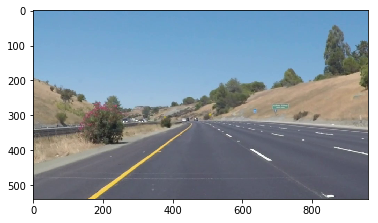

In [154]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [158]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(325, 654, 403, 596) -0.74358974359 895.666666667
(985, 624, 1046, 660) 0.590163934426 42.6885245902
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(325, 654, 403, 596) -0.74358974359 895.666666667
(985, 624, 1046, 660) 0.590163934426 42.6885245902
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|          | 2/251 [00:00<00:30,  8.29it/s]

(991, 626, 1033, 652) 0.619047619048 12.5238095238
(546, 497, 588, 469) -0.666666666667 861.0
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  1%|          | 3/251 [00:00<00:30,  8.09it/s]

(1052, 650, 1090, 672) 0.578947368421 40.9473684211
(445, 566, 475, 545) -0.7 877.5
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(531, 508, 564, 489) -0.575757575758 813.727272727
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(436, 575, 488, 541) -0.653846153846 860.076923077


  2%|▏         | 5/251 [00:00<00:28,  8.78it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(473, 553, 544, 500) -0.746478873239 906.084507042
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  3%|▎         | 7/251 [00:00<00:26,  9.34it/s]

(336, 664, 376, 628) -0.9 966.4
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  4%|▎         | 9/251 [00:00<00:24,  9.94it/s]

(405, 603, 512, 523) -0.747663551402 905.803738318
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(271, 685, 301, 661) -0.8 901.8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(446, 572, 528, 514) -0.707317073171 887.463414634
This image is:

  4%|▍         | 11/251 [00:01<00:24,  9.97it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(541, 452, 577, 474) 0.611111111111 121.388888889
(496, 538, 529, 513) -0.757575757576 913.757575758
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  5%|▍         | 12/251 [00:01<00:24,  9.57it/s]

(416, 583, 456, 557) -0.65 853.4
(1020, 645, 1055, 667) 0.628571428571 3.85714285714
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(531, 453, 572, 481) 0.682926829268 90.3658536585
(306, 661, 344, 635) -0.684210526316 870.368421053


  5%|▌         | 13/251 [00:01<00:30,  7.76it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(541, 503, 576, 473) -0.857142857143 966.714285714
(1063, 656, 1094, 674) 0.58064516129 38.7741935484


  6%|▌         | 14/251 [00:01<00:34,  6.86it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  6%|▌         | 15/251 [00:01<00:31,  7.57it/s]

(435, 571, 535, 499) -0.72 884.2
(1067, 656, 1098, 674) 0.58064516129 36.4516129032
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(510, 524, 588, 469) -0.705128205128 883.615384615
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(471, 553, 518, 517) -0.765957446809 913.765957447


  7%|▋         | 17/251 [00:01<00:29,  7.99it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  7%|▋         | 18/251 [00:02<00:35,  6.62it/s]

(393, 599, 434, 571) -0.682926829268 867.390243902
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|▊         | 19/251 [00:02<00:31,  7.26it/s]

(339, 638, 370, 617) -0.677419354839 867.64516129
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|▊         | 20/251 [00:02<00:30,  7.50it/s]

(325, 649, 356, 626) -0.741935483871 890.129032258
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  8%|▊         | 21/251 [00:02<00:31,  7.23it/s]

(386, 618, 444, 575) -0.741379310345 904.172413793
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


  9%|▉         | 22/251 [00:02<00:29,  7.72it/s]

(275, 683, 319, 651) -0.727272727273 883.0
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(346, 647, 463, 559)

 10%|▉         | 24/251 [00:03<00:39,  5.82it/s]

 -0.752136752137 907.239316239
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(1003, 637, 1043, 660) 0.575 60.275
(378, 608, 457, 554) -0.683544303797 866.379746835
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 10%|▉         | 25/251 [00:03<00:34,  6.64it/s]

(303, 679, 341, 651) -0.736842105263 902.263157895
(1008, 638, 1039, 658) 0.645161290323 -12.3225806452
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(1003, 699, 1036, 716) 0.515151515152 182.303030303
(516, 511, 553, 492) -0.513513513514 775.972972973
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 11%|█         | 27/251 [00:03<00:29,  7.69it/s]

(1038, 657, 1072, 676) 0.558823529412 76.9411764706
(534, 497, 583, 468) -0.591836734694 813.040816327
This image is:

 11%|█         | 28/251 [00:03<00:27,  8.10it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(332, 642, 372, 612) -0.75 891.0
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(555, 499, 579, 469) -1.25 1192.75
(309, 656, 342, 682) 0.787878787879 412.545454545
(548, 498, 583, 467) -0.885714285714 983.371428571


 12%|█▏        | 29/251 [00:03<00:26,  8.49it/s]

This image is:

 12%|█▏        | 31/251 [00:03<00:24,  8.87it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(278, 677, 333, 639) -0.690909090909 869.072727273
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(294, 683, 505, 524) -0.75355450237 904.545023697
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 13%|█▎        | 32/251 [00:03<00:24,  8.82it/s]

(268, 683, 300, 661) -0.6875 867.25
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(306, 655, 364, 615) -0.689655172414 866.034482759


 14%|█▍        | 35/251 [00:04<00:26,  8.18it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(315, 648, 357, 619) -0.690476190476 865.5
(487, 542, 512, 512) -1.2 1126.4
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(965, 616, 1000, 639) 0.657142857143 -18.1428571429
(360, 615, 416, 578) -0.660714285714 852.857142857
This image is:

 14%|█▍        | 36/251 [00:04<00:30,  7.06it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(472, 541, 516, 511) -0.681818181818 862.818181818
(996, 637, 1055, 672) 0.593220338983 46.1525423729
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 15%|█▍        | 37/251 [00:04<00:46,  4.62it/s]

(1034, 645, 1073, 667) 0.564102564103 61.7179487179
(394, 619, 427, 593) -0.787878787879 929.424242424
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(263, 681, 439, 562) -0.676136363636 858.823863636
(989, 632, 1043, 664) 0.592592592593 45.9259259259
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 16%|█▋        | 41/251 [00:05<00:39,  5.38it/s]

(1030, 657, 1072, 678) 0.5 142.0
(386, 609, 422, 585) -0.666666666667 866.333333333
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(382, 614, 434, 574) -0.769230769231 907.846153846
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(403, 586, 465, 543) -0.693548387097 865.5
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 17%|█▋        | 43/251 [00:05<00:31,  6.60it/s]

(401, 598, 455, 561) -0.685185185185 872.759259259
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(279, 671, 315, 645) -0.722222222222 872.5
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|█▊        | 44/251 [00:05<00:36,  5.65it/s]

(292, 678, 339, 645) -0.702127659574 883.021276596
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(295, 661, 367, 611) -0.694444444444 865.861111111
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 18%|█▊        | 46/251 [00:06<00:30,  6.67it/s]

(285, 668, 396, 595) -0.657657657658 855.432432432
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(265, 684, 572, 477) -0.674267100977 862.680781759
(982, 623, 1028, 650) 0.586956521739 46.6086956522


 19%|█▊        | 47/251 [00:06<00:37,  5.44it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(993, 629, 1066, 672) 0.58904109589 44.0821917808
(544, 503, 579, 478) -0.714285714286 891.571428571


 19%|█▉        | 48/251 [00:06<00:44,  4.51it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(376, 610, 424, 578) -0.666666666667 860.666666667
(1042, 646, 1095, 675) 0.547169811321 75.8490566038


 20%|█▉        | 49/251 [00:07<00:54,  3.71it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 20%|█▉        | 50/251 [00:07<01:04,  3.11it/s]

(379, 621, 442, 576) -0.714285714286 891.714285714
(1006, 639, 1050, 665) 0.590909090909 44.5454545455


 20%|██        | 51/251 [00:07<00:54,  3.64it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(368, 630, 404, 604) -0.722222222222 895.777777778
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 21%|██        | 52/251 [00:07<00:51,  3.87it/s]

(268, 685, 298, 664) -0.7 872.6
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(300, 664, 370, 614) -0.714285714286 878.285714286


 21%|██        | 53/251 [00:08<00:43,  4.58it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(314, 652, 355, 623) -0.707317073171 874.097560976


 22%|██▏       | 55/251 [00:08<00:44,  4.37it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(413, 596, 452, 568) -0.717948717949 892.512820513
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 23%|██▎       | 58/251 [00:08<00:32,  5.89it/s]

(272, 684, 307, 660) -0.685714285714 870.514285714
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(274, 682, 325, 647) -0.686274509804 870.039215686
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(527, 512, 582, 477) -0.636363636364 847.363636364
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|██▎       | 59/251 [00:09<00:30,  6.22it/s]

(272, 684, 364, 619) -0.70652173913 876.173913043
(1032, 642, 1065, 659) 0.515151515152 110.363636364
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 24%|██▍       | 61/251 [00:09<00:29,  6.37it/s]

(441, 575, 472, 551) -0.774193548387 916.419354839
(1013, 644, 1067, 676) 0.592592592593 43.7037037037
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(368, 614, 410, 585) -0.690476190476 868.095238095
(1005, 638, 1040, 660) 0.628571428571 6.28571428571
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(1013, 640, 1073, 677) 0.616666666667 15.3166666667
(297, 680, 330, 656) -0.727272727273 896.0


 25%|██▌       | 63/251 [00:09<00:26,  7.00it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(300, 678, 333, 654) -0.727272727273 896.181818182
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 25%|██▌       | 64/251 [00:09<00:27,  6.88it/s]

(323, 659, 365, 629) -0.714285714286 889.714285714
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 26%|██▋       | 66/251 [00:10<00:27,  6.70it/s]

(404, 623, 441, 593) -0.810810810811 950.567567568
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(543, 510, 574, 477) -1.06451612903 1088.03225806
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██▋       | 68/251 [00:10<00:25,  7.30it/s]

(488, 542, 527, 513) -0.74358974359 904.871794872
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(484, 537, 584, 472) -0.65 851.6
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 27%|██▋       | 69/251 [00:10<00:29,  6.25it/s]

(505, 522, 568, 482) -0.634920634921 842.634920635
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(494, 531, 537, 503) -0.651162790698 852.674418605


 28%|██▊       | 70/251 [00:10<00:34,  5.20it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 28%|██▊       | 71/251 [00:11<01:05,  2.74it/s]

(353, 631, 387, 606) -0.735294117647 890.558823529
(461, 572, 487, 537) -1.34615384615 1192.57692308
(465, 428, 496, 444) 0.516129032258 188.0
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 29%|██▊       | 72/251 [00:12<01:09,  2.56it/s]

(476, 429, 506, 444) 0.5 191.0
(425, 486, 451, 447) -1.5 1123.5
(399, 598, 431, 577) -0.65625 859.84375
This image is:

 29%|██▉       | 73/251 [00:12<01:24,  2.10it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(411, 488, 440, 451) -1.27586206897 1012.37931034
(406, 497, 444, 450) -1.23684210526 999.157894737
(390, 497, 430, 470) -0.675 760.25
(1024, 639, 1083, 674) 0.593220338983 31.5423728814
This image is:

 29%|██▉       | 74/251 [00:13<01:33,  1.89it/s]

 <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(387, 503, 412, 473) -1.2 967.4
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


 30%|██▉       | 75/251 [00:14<01:46,  1.66it/s]

(536, 514, 591, 471) -0.781818181818 933.054545455
(351, 636, 396, 605) -0.688888888889 877.8
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(313, 683, 364, 644) 

 30%|███       | 76/251 [00:14<01:56,  1.50it/s]

-0.764705882353 922.352941176
(439, 586, 505, 538) -0.727272727273 905.272727273
This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(380, 631, 420, 602) -0.725 906.5


 31%|███       | 77/251 [00:16<02:35,  1.12it/s]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(457, 430, 494, 451) 0.567567567568 170.621621622
(441, 586, 474, 562) -0.727272727273 906.727272727


 31%|███       | 78/251 [00:17<02:54,  1.01s/it]

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)
(464, 428, 500, 451) 0.638888888889 131.555555556
(529, 521, 571, 487) -0.809523809524 949.238095238
(447, 451, 477, 433) -0.6 719.2


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file test_videos_output/challenge.mp4:

 b''

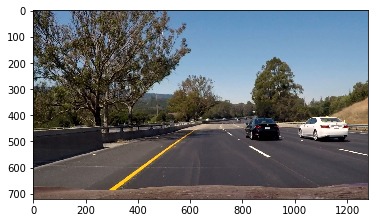

In [163]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [164]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))